# Motor de predicción de bajas
El objetivo es entrenar un modelo que prediga las bajas de clientes.

### Importación de librerías:

In [318]:
import pandas as pd
import numpy as np
import missingno as msno
import matplotlib.pyplot as plt
import datetime
from datetime import timedelta
import seaborn as sns


import sklearn
from sklearn.model_selection       import train_test_split
from sklearn.model_selection       import cross_val_score
from sklearn.metrics               import classification_report
from sklearn.metrics               import confusion_matrix

from sklearn                       import svm
from sklearn                       import model_selection
from sklearn.linear_model          import LogisticRegression
from sklearn.tree                  import DecisionTreeClassifier
from sklearn.neighbors             import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes           import GaussianNB
from sklearn.ensemble              import RandomForestRegressor
from sklearn.ensemble              import RandomForestClassifier

### Carga de datos

In [139]:
datos_2018 = pd.read_csv("data/DM_CARTERA_YTD_2018.csv", sep=";", encoding="ISO-8859-1")
datos_2019 = pd.read_csv("data/DM_CARTERA_YTD_2019.csv", sep=";", encoding="ISO-8859-1")
datos_2020 = pd.read_csv("data/DM_CARTERA_YTD_2020.csv", sep=";", encoding="ISO-8859-1")

C:\Users\daniel.pascual\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3057: DtypeWarning: Columns (28,87) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
C:\Users\daniel.pascual\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3057: DtypeWarning: Columns (87,94) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
C:\Users\daniel.pascual\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3057: DtypeWarning: Columns (87,92,94) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Antes de juntar los tres años en un solo dataframe, vamos a asegurarnos de que las columnas son las mismas.

In [140]:
print("Número de columnas en los datos de 2018:", datos_2018.shape[1])
print("Número de columnas en los datos de 2019:", datos_2019.shape[1])
print("Número de columnas en los datos de 2020:", datos_2020.shape[1])

columnas_totales = datos_2018.columns + datos_2019.columns + datos_2020.columns
columnas_distintas = set(columnas_totales)
print("Número de columnas distintas:", len(columnas_distintas))

Número de columnas en los datos de 2018: 130
Número de columnas en los datos de 2019: 130
Número de columnas en los datos de 2020: 130
Número de columnas distintas: 130


Los tres conjuntos de datos tienen idénticas columnas, así que podemos juntarlos y trabajar con uno solo

In [141]:
df = pd.concat([datos_2018,datos_2019,datos_2020])
df.head()

,ID_CIERRE,ANIO_CARTERA,MES_CARTERA,NUM_LOTE_CARTERA,TIPO_OPERACION,IND_CARTERA,FLG_RENUEVA,COD_POLIZA,FLG_POLIZA_COLECTIVA,COD_TIPO_POLIZA,DES_FORMA_CONTRATA,COD_FORMA_PAGO,DES_FORMA_PAGO,COD_MODO_PAGO,DES_MODO_PAGO,COD_BANCO,DES_BANCO,NUM_SUPLEMENTO_REGULADOR,NUM_SUPLEMENTO,FEC_ALTA_POLIZA,FEC_EFECTO_POLIZA,FEC_VCTO_POLIZA,FEC_BAJA_POLIZA,FEC_GRABACION_BAJA,COD_CAUSA_ANULACION,DES_CAUSA_ANULACION,COD_MODALIDAD_ANT,COD_MODALIDAD_REG,COD_MODALIDAD_ACT,VAL_MUT_G,VAL_MUT_5,VAL_MUT_1,NUM_POLIZAS,NUM_ANTIGUEDAD_POLIZA,NUM_ANTI_MUTUALISTA,EDAD,NUM_ANTI_CARNET,FLG_CONDUCTOR_HAB,NUM_CONDUCTORES,COD_PROVINCIA,COD_ZONA_TARIFA,NOTABUREAU,NOTAGLOBAL,NOTA_FACTOR_EXPERIAN,FACTOR_EXPERIAN,IMP_ANUALIDAD_ANTERIOR,IMP_PRIMA_TARIFICADOR_RENOVACION,COD_REGULADOR,PORC_REGULADOR,IMP_DIFERENCIA,...,COD_POSTAL_COND_HABITUAL,COD_TIPO_VEHICULO,DESC_TIPO_VEHICULO,COD_VEHICULO,NUM_ANTI_MATRICULA,COD_GRUPO_TARIFA,DESC_GRUPO_TARIFICACION,COD_REMOLQUE,NUM_POTENCIA_VEHICULO,DESC_MARCA,DESC_MODELO_VERSION,COD_COMBUSTIBLE,NUM_PUERTAS,IMP_VALOR_VEHICULO,FLG_BUEN_MUTUALISTA,FLG_VEHICULO_NUEVO,FLG_RECARGO_CONDUCTOR_RCO,FLG_RECARGO_CONDUCTOR_DANOS,IMPORTE_TOTAL_DESCUENTO,IMP_DESC_EMPLEADOS_TOTAL,IMP_DESC_COMERCIAL_TOTAL,FLG_DESC_PRECAMPANA,IMP_DESC_PRECAMPANA,FLG_DESC_CAMPANA,IMP_DESC_CAMPANA,FLG_DESC_ESPECIAL,IMP_DESC_ESPECIAL,COD_TIPO_BOLSA_DESCUENTO,FLG_DESC_BOLSA_RETENCION,IMP_DESC_BOLSA_RETENCION,FLG_DESC_REGULADOR,IMP_DESC_REGULADOR,FLG_PRECAM_BUEN_MUTUALISTA,IMP_PRECAM_BUEN_MUTUALISTA,FLG_PRECAM_NUEVO_VEHICULO,IMP_PRECAM_NUEVO_VEHICULO,FLG_PRECAM_MULTIPACK,IMP_PRECAM_MULTIPACK,FLG_CAMPANA_EMPLEADOS,IMP_DESC_EMPLEADOS,FLG_CAMP_EMPL_COLABORADOR,IMP_CAMP_EMPL_COLABORADOR,FLG_CAMPANA_PROV,IMP_CAMPANA_PROV,FLG_CAMP_MOTOS50,IMP_CAMP_MOTOS50,FLG_CAMP_MUTUALISTA_PROPIETARIO,IMP_CAMP_MUTUALISTA_PROPIETARIO,FLG_CAMP_DESC_ESPECIAL,IMP_CAMP_DESC_ESPECIAL
0,201901,2018,201810,5976,RENOR,1,1,300002300,0,A,Anual renovable,A,Anual,B,Por Banco,81,BANCO DE SABADELL S.A.,6,6,19651014,20181014,20191013,0,4000-01-01,-1,No Aplica,MB,MB,MB,AB,A9,A9,1,"0053,04","0011,21","0067,86","0049,79",S,1,28,C,Z,C,CZ,"-03,000","000000115,73","000000119,36",BA,"-000000011,93","0000000003,63",...,0,TUR,TUR - TURISMO,124009200,"0053,04",11,11 - Automóviles hasta 28 CV,-1,25,SEAT,600,G,0,"000004809,00",0,0,0,"0,","-0000000016,18","000000000,000","-000000016,180","0,","0000000,00000","0,","0000000,00000","0,","0000000,00000",XX,"0,","000000,000000","1,","-0000016,18000","0,","0000000,00000","0,","0000000,00000","0,","0000000,00000","0,","0000000,00000","0,","0000000,00000","0,","0000000,00000","0,","0000000,00000","0,","0000000,00000","0,","0000000,00000"
1,201804,2018,201801,5592,RENOR,1,1,300011140,0,A,Anual renovable,A,Anual,B,Por Banco,182,BANCO BILBAO VIZCAYA ARGENTARIA (BBVA),6,6,19670113,20180113,20190112,0,4000-01-01,-1,No Aplica,MB,MB,NaN,AB,A9,A9,1,"0051,04","0051,04","0082,82","0030,39",S,1,48,B,Z,C,CZ,"-03,000","000000157,11","000000160,25",BA,"-000000000,01","0000000003,14",...,0,TUR,TUR - TURISMO,124009300,"0051,04",11,11 - Automóviles hasta 28 CV,-1,25,SEAT,600-D,G,0,"000004809,00",0,0,0,"0,","-0000000000,01","000000000,000","-000000000,010","0,","0000000,00000","0,","0000000,00000","0,","0000000,00000",XX,"0,","000000,000000","0,","-0000000,01000","0,","0000000,00000","0,","0000000,00000","0,","0000000,00000","0,","0000000,00000","0,","0000000,00000","0,","0000000,00000","0,","0000000,00000","0,","0000000,00000","0,","0000000,00000"
2,201806,2018,201803,5661,RENOR,1,1,300020775,0,A,Anual renovable,A,Anual,B,Por Banco,49,BANCO SANTANDER S.A.,6,6,19680330,20180330,20190329,0,4000-01-01,-1,No Aplica,MB,MB,NaN,AB,A9,A9,0,"0050,03","0050,03","0065,52","0030,85",S,1,28,C,Z,D,DZ,"-02,000","000000197,75","000000203,77",BA,"-000000005,14","0000000006,02",...,0,TUR,TUR - TURISMO,124008500,"0050,03",15,15 - Automóviles de 54 a 75 CV,-1,75,SEAT,1500,G,0,"000006912,00",0,0,0,"0,","-0000000011,04","000000000,000","-000000011,040","0,","0000000,00000","0,","0000000,00000","0,","0000000,00000",X

## Preprocesado de datos

### Análisis inicial de los datos

In [142]:
print("Tamaño del dataset:", df.shape)
print("Número de columnas:", df.shape[1])
print("Número de registros:", df.shape[0])

Tamaño del dataset: (849206, 130)
Número de columnas: 130
Número de registros: 849206


In [143]:
pd.set_option('display.max_rows', 150)
pd.set_option('display.max_columns', 100)
df.dtypes

ID_CIERRE                            int64
ANIO_CARTERA                         int64
MES_CARTERA                          int64
NUM_LOTE_CARTERA                     int64
TIPO_OPERACION                      object
IND_CARTERA                          int64
FLG_RENUEVA                          int64
COD_POLIZA                           int64
FLG_POLIZA_COLECTIVA                 int64
COD_TIPO_POLIZA                     object
DES_FORMA_CONTRATA                  object
COD_FORMA_PAGO                      object
DES_FORMA_PAGO                      object
COD_MODO_PAGO                       object
DES_MODO_PAGO                       object
COD_BANCO                            int64
DES_BANCO                           object
NUM_SUPLEMENTO_REGULADOR             int64
NUM_SUPLEMENTO                       int64
FEC_ALTA_POLIZA                      int64
FEC_EFECTO_POLIZA                    int64
FEC_VCTO_POLIZA                      int64
FEC_BAJA_POLIZA                      int64
FEC_GRABACI

### Análisis de estadísticos

#### Valores numéricos

In [144]:
df.describe()

,ID_CIERRE,ANIO_CARTERA,MES_CARTERA,NUM_LOTE_CARTERA,IND_CARTERA,FLG_RENUEVA,COD_POLIZA,FLG_POLIZA_COLECTIVA,COD_BANCO,NUM_SUPLEMENTO_REGULADOR,NUM_SUPLEMENTO,FEC_ALTA_POLIZA,FEC_EFECTO_POLIZA,FEC_VCTO_POLIZA,FEC_BAJA_POLIZA,COD_CAUSA_ANULACION,NUM_POLIZAS,NUM_CONDUCTORES,COD_PROVINCIA,ID_TRAMO_BONUS,COD_OFICINA_GESTORA,COD_OFICINA_ABRIDORA,COD_AGENTE,COD_PROFESION,TOT_SINIESTROS,SINISESTROS_ACTUAL,COD_TIPO_SINIESTRO,NUM_SINIESTRO,NUM_SINIESTRO_DESF,NUM_SINIESTRO_FAV,FEC_NAC_COND_PRINCIPAL,FEC_CARNET_COND_PRINCIPAL,COD_POSTAL_COND_PRINCIPAL,FEC_NAC_COND_HABITUAL,FEC_CARNET_COND_HABITUAL,COD_POSTAL_COND_HABITUAL,COD_VEHICULO,COD_GRUPO_TARIFA,NUM_POTENCIA_VEHICULO,FLG_RECARGO_CONDUCTOR_RCO
count,849206.000000,849206.000000,849206.000000,849206.000000,849206.000000,849206.000000,8.492060e+05,849206.000000,849206.000000,849206.000000,849206.000000,8.492060e+05,8.492060e+05,8.492060e+05,8.492060e+05,849206.000000,849206.000000,849206.000000,849206.000000,849206.000000,849206.000000,849206.000000,849206.000000,849206.000000,849206.000000,849206.000000,849206.000000,849206.000000,849206.000000,849206.000000,8.492060e+05,8.492060e+05,849206.000000,8.492060e+05,8.492060e+05,849206.000000,8.492060e+05,849206.000000,849206.000000,849206.000000
mean,201931.523448,2019.004170,201906.927609,6326.794144,0.988187,0.882513,3.012143e+08,0.001815,1163.150985,5.737173,6.098165,2.011056e+07,2.019015e+07,2.020012e+07,2.372162e+06,4.443550,2.355447,1.368179,26.263724,-0.021673,262.914265,262.825798,15852.746741,57.106636,2.016686,0.202762,0.326527,0.279251,0.148701,0.130550,1.931089e+07,1.954007e+07,26484.322531,2.275405e+06,2.299242e+06,2911.937997,1.068560e+08,18.543529,107.955065,0.044775
std,91.037634,0.815922,81.655814,422.718317,0.108046,0.322000,2.840629e+05,0.042560,1110.694964,2.793477,2.862306,7.623082e+04,8.518552e+03,8.529870e+03,6.501439e+06,16.460065,1.700965,0.629177,13.671757,0.542953,136.715494,136.732668,25002.175745,157.172741,3.175869,0.546266,0.715293,0.672598,0.523038,0.383307,2.557007e+06,2.627046e+06,13683.789931,6.292423e+06,6.362495e+06,9438.336178,7.922217e+07,5.725009,52.031764,0.206809
min,201804.000000,2018.000000,201801.000000,5592.000000,0.000000,0.000000,3.000023e+08,0.000000,-1.000000,1.000000,1.000000,1.965010e+07,2.016063e+07,2.017063e+07,0.000000e+00,-1.000000,0.000000,0.000000,1.000000,-5.000000,10.000000,10.000000,10.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000,1.001100e+06,11.000000,-40.000000,0.000000
25%,201901.000000,2018.000000,201810.000000,5970.000000,1.000000,1.000000,3.010429e+08,0.000000,81.000000,4.000000,4.000000,2.006120e+07,2.018091e+07,2.019090e+07,0.000000e+00,-1.000000,1.000000,1.000000,15.000000,0.000000,150.000000,150.000000,250.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.954091e+07,1.977091e+07,15008.000000,0.000000e+00,0.000000e+00,0.000000,4.506905e+07,16.000000,80.000000,0.000000
50%,201910.000000,2019.000000,201907.000000,6398.000000,1.000000,1.000000,3.012977e+08,0.000000,1465.000000,5.000000,6.000000,2.014100e+07,2.019062e+07,2.020062e+07,0.000000e+00,-1.000000,2.000000,1.000000,28.000000,0.000000,281.000000,280.000000,450.000000,14.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.963122e+07,1.988072e+07,28035.000000,0.000000e+00,0.000000e+00,0.000000,1.050544e+08,17.000000,105.000000,0.000000
75%,202007.000000,2020.000000,202004.000000,6730.000000,1.000000,1.000000,3.014392e+08,0.000000,2100.000000,7.000000,8.000000,2.017043e+07,2.020032e+07,2.021032e+07,0.000000e+00,-1.000000,3.000000,2.000000,36.000000,0.000000,361.000000,361.000000,28034.000000,41.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.976101e+07,1.999101e+07,36900.000000,0.000000e+00,0.000000e+00,0.000000,1.440166e+08,17.000000,136.000000,0.000000
max,202102.000000,2020.000000,202012.000000,7172.000000,1.000000,1.000000,3.093482e+08,1.000000,9998.000000,35.000000,35.000000

* El campo ANIO_CARTERA parece contener simplemente el año. No nos aporta demasiado tal como está, así que podremos quitarlo.
* El campo MES_CARTERA viene en formato 'añomes', podemos extraer el mes por si la época del año influye en la renovación o no.
* El campo FLG_RENUEVA es el target, no se lo podemos dar al modelo, pero lo conservamos de momento ya que lo utilizaremos para entrenar
* El campo COD_POLIZA parece un identificador de la póliza, no aporta a este tipo de estudio.

Veamos si hay columnas con un solo valor, que no aportan nada y deberemos eliminar

In [145]:
todas_utiles = True
for col in df:
    if(len(df.loc[:,col].unique()) == 1):
        print("La columna ", col, " solo tiene un valor, se podré eliminar")
        todas_utiles = False
if todas_utiles:
    print("Todas las columnas tienen dos o más valores distintos")

Todas las columnas tienen dos o más valores distintos


No se da el caso.

#### Valores categóricos

In [146]:
df.describe(include='object')

,TIPO_OPERACION,COD_TIPO_POLIZA,DES_FORMA_CONTRATA,COD_FORMA_PAGO,DES_FORMA_PAGO,COD_MODO_PAGO,DES_MODO_PAGO,DES_BANCO,FEC_GRABACION_BAJA,DES_CAUSA_ANULACION,COD_MODALIDAD_ANT,COD_MODALIDAD_REG,COD_MODALIDAD_ACT,VAL_MUT_G,VAL_MUT_5,VAL_MUT_1,NUM_ANTIGUEDAD_POLIZA,NUM_ANTI_MUTUALISTA,EDAD,NUM_ANTI_CARNET,FLG_CONDUCTOR_HAB,COD_ZONA_TARIFA,NOTABUREAU,NOTAGLOBAL,NOTA_FACTOR_EXPERIAN,FACTOR_EXPERIAN,IMP_ANUALIDAD_ANTERIOR,IMP_PRIMA_TARIFICADOR_RENOVACION,COD_REGULADOR,PORC_REGULADOR,IMP_DIFERENCIA,IMP_PRIMA_RENOV_FINAL,NUM_BONUS_ANTERIOR,NUM_BONUS_ACTUAL,DES_TRAMO_BONUS,DESC_OFICINA_GESTORA,DESC_OFICINA_ABRIDORA,COD_TIPO_CLIENTE,DES_TIPO_CLIENTE,ID_REL_PROFESION,DESC_TITULACION,DESC_PROFESION,GASTO_TOTAL,GASTO_TOTAL_ACTUAL,DES_TIPO_SINIESTRO,COD_TIPO_VEHICULO,DESC_TIPO_VEHICULO,NUM_ANTI_MATRICULA,DESC_GRUPO_TARIFICACION,COD_REMOLQUE,DESC_MARCA,DESC_MODELO_VERSION,COD_COMBUSTIBLE,NUM_PUERTAS,IMP_VALOR_VEHICULO,FLG_BUEN_MUTUALISTA,FLG_VEHICULO_NUEVO,FLG_RECARGO_CONDUCTOR_DANOS,IMPORTE_TOTAL_DESCUENTO,IMP_DESC_EMPLEADOS_TOTAL,IMP_DESC_COMERCIAL_TOTAL,FLG_DESC_PRECAMPANA,IMP_DESC_PRECAMPANA,FLG_DESC_CAMPANA,IMP_DESC_CAMPANA,FLG_DESC_ESPECIAL,IMP_DESC_ESPECIAL,COD_TIPO_BOLSA_DESCUENTO,FLG_DESC_BOLSA_RETENCION,IMP_DESC_BOLSA_RETENCION,FLG_DESC_REGULADOR,IMP_DESC_REGULADOR,FLG_PRECAM_BUEN_MUTUALISTA,IMP_PRECAM_BUEN_MUTUALISTA,FLG_PRECAM_NUEVO_VEHICULO,IMP_PRECAM_NUEVO_VEHICULO,FLG_PRECAM_MULTIPACK,IMP_PRECAM_MULTIPACK,FLG_CAMPANA_EMPLEADOS,IMP_DESC_EMPLEADOS,FLG_CAMP_EMPL_COLABORADOR,IMP_CAMP_EMPL_COLABORADOR,FLG_CAMPANA_PROV,IMP_CAMPANA_PROV,FLG_CAMP_MOTOS50,IMP_CAMP_MOTOS50,FLG_CAMP_MUTUALISTA_PROPIETARIO,IMP_CAMP_MUTUALISTA_PROPIETARIO,FLG_CAMP_DESC_ESPECIAL,IMP_CAMP_DESC_ESPECIAL
count,849206,849206,849206,849206,849206,849206,849206,849206,849206,849206,849206,849206,637230,849206,824803,824803,849206,849206,849206,849206,849205,849206,847820,847820,847820,849206,849206,849206,849204,849206,849206,849206,849206,849206,849206,849206,849206,849201,849206,849206,849206,849206,849206,849206,849206,849203,849202,849206,849206,849206,849206,849206,825335,849206,849206,849206,849206,849206,849206,849206,849206,849206,849206,849206,849206,849206,849206,849206,849206,849206,849206,849206,849206,849206,849206,849206,849206,849206,849206,849206,849206,849206,849206,849206,849206,849206,849206,849206,849206,849206
unique,12,3,3,7,7,3,3,155,967,31,61,59,58,13,14,14,1135,4631,8155,7125,2,3,7,11,20,10,102872,104993,6,11983,31859,101956,16,15,8,70,78,11,12,2,8,272,201964,68023,4,45,44,5472,27,5,306,43088,7,14,24400,4,3,2,80215,6345,80088,2,7411,2,14434,2,2493,4,2,18413,2,344308,2,1093,2,317,2,24,2,2896,2,4326,2,3014,2,108,2,208,2,952
top,RENOR,A,Anual renovable,A,Anual,B,Por Banco,CAIXABANK S.A.,4000-01-01,No Aplica,MI,MI,MI,AB,A9,A9,"0001,00","0001,00","0000,00","0000,00",S,B,Z,E,EZ,"00,000","000000000,00","000000155,44",BA,"000000000,00","0000000000,00","0000000155,44","-0050,00","-0050,00",0 - Sin cambio en el nivel de bonus,180 - OF. GRANADA,180 - OF. GRANADA,1,1 - Licenciado Sanitario,1 - Sanitaria,9 - OTRAS PROFESIONES,1 - MÉDICO,"000000000000000,00","000000000000000,00",0 - Sin Siniestros,BER,BER - BERLINA,"0002,00",17 - Automóviles de 119 a 215 CV,-1,VOLKSWAGEN,"Hasta 750 PMA. Y Hasta 8,5 MTS.",D,5,"000008000,00",0,0,"0,","0000000000,00","000000000,000",0,"0,","0000000,00000","0,","0000000,00000","0,","0000000,00000",XX,"0,","000000,000000","1,","0000000,00000","0,","0000000,00000","0,","0000000,00000","0,","0000000,00000","0,","0000000,00000","0,","0000000,00000","0,","0000000,00000","0,","0000000,00000","0,","0000000,00000","0,","0000000,00000"
freq,771806,849163,849163,586575,586575,822868,822868,113127,749435,749435,234428,233892,177148,280208,312930,254821,139042,25364,14339,16801,751493,434694,816696,236971,236971,240992,1319,1117,561937,43529,7338,800,748103,743451,694285,53116,51599,323748,323748,483635,383058,224276,367868,721471,678581,408047,408047,12991,294012,652336,79550,2518,467780,477564,18942,444989,824626,822256,39568,79804

In [147]:
todas_utiles = True
for var in df.describe(include='object'):
    categorias = df[var].unique()
    num_categorias = len(categorias)
    print('Categorías de', var, ':',categorias)
    print('Categorías distintas:',num_categorias)
    if (num_categorias == 1):
        todas_utiles = False
        print("La categoría de ", var, "solo tiene un valor distinto y deberá ser eliminada")
if todas_utiles:
    print("Todas las columnas tienen dos o más valores distintos")

Categorías de TIPO_OPERACION : ['RENOR' 'REH_CART' 'RENONR' 'SUPLR' 'BAJA' 'SUPLCA' 'SUPLRNP' 'EMIS'
 'SUPL' 'REHAB' 'RENOR     ' 'SUSP']
Categorías distintas: 12
Categorías de COD_TIPO_POLIZA : ['A' 'R' '-1']
Categorías distintas: 3
Categorías de DES_FORMA_CONTRATA : ['Anual renovable' 'Temporal de ajuste Remolques' 'No Informado']
Categorías distintas: 3
Categorías de COD_FORMA_PAGO : ['A' 'S' 'T' 'U' 'E' 'R' '-1']
Categorías distintas: 7
Categorías de DES_FORMA_PAGO : ['Anual' 'Semestral' 'Trimestral' 'Unica' 'Semestral sin recargo'
 'Trimestral sin recargo' 'No Informado']
Categorías distintas: 7
Categorías de COD_MODO_PAGO : ['B' 'C' '-1']
Categorías distintas: 3
Categorías de DES_MODO_PAGO : ['Por Banco' 'Por Caja' 'No Informado']
Categorías distintas: 3
Categorías de DES_BANCO : ['BANCO DE SABADELL S.A.' 'BANCO BILBAO VIZCAYA ARGENTARIA (BBVA)'
 'BANCO SANTANDER S.A.' 'BANCO MARE NOSTRUM S.A.' 'BARCLAYS BANK S.A'
 'BANCO ESPAÑOL DE CREDITO S.A.' 'No Informado'
 'C.A.DE CASTILLA 

Categorías de COD_MODALIDAD_ANT : ['MB' 'MS' 'ML' 'MI' 'BB' 'MF' 'CL' 'MM' 'MC' '19' 'CI' 'XL' 'G4' 'MX'
 'G1' '05' 'G2' 'G5' 'XS' '44' '17' 'G6' 'XI' 'XF' '06' '38' 'CB' '21'
 '34' 'XB' 'G3' '39' 'G7' 'MQ' 'IM' 'G8' '29' '43' '50' 'G9' '15' '46'
 '26' '31' 'R1' 'RB' 'R2' 'RI' 'RS' 'RT' 'MT' 'RL' 'RM' '23' 'R3' '81'
 'CG' 'CX' '36' '08' '  ']
Categorías distintas: 61
Categorías de COD_MODALIDAD_REG : ['MB' 'MS' 'ML' 'MI' 'BB' 'MF' 'CL' 'MM' 'MC' '19' 'CI' 'XL' 'G4' 'MX'
 'G1' '05' 'G2' 'G5' 'XS' '44' '17' 'CB' 'G6' 'XI' 'XF' '06' '38' '21'
 '34' 'XB' 'G3' '39' 'G7' 'MQ' 'IM' 'G8' '29' '43' 'G9' '15' '46' '26'
 '31' 'R1' 'RB' 'R2' 'RI' 'RS' 'RT' 'MT' 'RL' 'RM' '23' 'R3' '81' 'CX'
 'CG' '36' '08']
Categorías distintas: 59
Categorías de COD_MODALIDAD_ACT : ['MB' nan 'MS' 'MI' 'MM' 'ML' 'MF' 'G4' 'CI' 'MX' 'CL' 'XL' 'BB' 'G1' 'G2'
 'MC' '44' 'XI' 'XF' 'G5' 'G6' '34' '19' 'XB' '21' 'G3' 'CB' 'G7' 'G8'
 'XS' 'G9' '39' '15' '06' '46' 'IM' 'RB' 'R1' 'RI' 'MT' 'RL' 'MQ' '81'
 'RM' 'R2' 'RS' 'CX

Categorías de GASTO_TOTAL_ACTUAL : [' 000000000000000,00' ' 000000000000029,00' '-000000000000478,76' ...
 ' 000000000000672,33' '-000000000000590,99' '-000000000000462,86']
Categorías distintas: 68023
Categorías de DES_TIPO_SINIESTRO : ['0 - Sin Siniestros' '1 - Favorable' '2 - Desfavorable' '3 - Ambos']
Categorías distintas: 4
Categorías de COD_TIPO_VEHICULO : ['TUR' 'BER' 'MOT' 'TOT' 'CPE' 'MNV' 'CIC' 'COM' 'FUR' 'FAM' 'BUS' 'CBR'
 'Sco' 'AUT' 'CAR' 'ROA' 'PIC' 'Mdc' 'Cus' 'TDT' 'CHA' 'SC1' 'PDC' 'SC2'
 'Tra' 'QUA' 'ELE' 'MCR' 'Mca' 'DC' 'REM' 'END' 'TAR' 'CGF' 'SPE' '3ru'
 'NAK' 'AMB' 'ACV' 'SPR' nan 'TMD' 'TRI' 'VMA' 'NOT' 'BGY']
Categorías distintas: 46
Categorías de DESC_TIPO_VEHICULO : ['TUR - TURISMO' 'BER - BERLINA' 'MOT - MOTOCICLETA' 'TOT - ALL-ROAD'
 'CPE - COUPE' 'MNV - MONOVOLUMEN' 'CIC - CICLOMOTOR' 'COM - COMERCIAL'
 'FUR - FURGONETAS' 'FAM - FAMILIAR' 'BUS - AUTOBUS' 'CBR - CABRIO'
 'Sco - SCOOTER' 'AUT - AUTOMOVIL' 'CAR - CARAVANAS' 'ROA - ROADSTER'
 'PIC - PICK-UP' 

Categorías de FLG_DESC_REGULADOR : [' 1,' ' 0,']
Categorías distintas: 2
Categorías de IMP_DESC_REGULADOR : ['-0000016,18000' '-0000000,01000' '-0000011,04000' ... ' 0000163,02915'
 '-0000068,73569' '-0000057,88772']
Categorías distintas: 344308
Categorías de FLG_PRECAM_BUEN_MUTUALISTA : [' 0,' ' 1,']
Categorías distintas: 2
Categorías de IMP_PRECAM_BUEN_MUTUALISTA : [' 0000000,00000' '-0000043,64381' '-0000036,02800' ... '-0000050,91700'
 '-0000079,60330' '-0000058,93080']
Categorías distintas: 1093
Categorías de FLG_PRECAM_NUEVO_VEHICULO : [' 0,' ' 1,']
Categorías distintas: 2
Categorías de IMP_PRECAM_NUEVO_VEHICULO : [' 0000000,00000' '-0000036,11142' '-0000054,01570' '-0000026,01666'
 '-0000036,99500' '-0000030,44571' '-0000116,35428' '-0000042,62856'
 '-0000030,28275' '-0000156,54660' '-0000061,81500' '-0000083,08888'
 '-0000059,77666' '-0000067,68856' '-0000125,48500' '-0000069,90750'
 '-0000028,75500' '-0000069,49999' '-0000032,72049' '-0000090,43750'
 '-0000071,03000' '-0000099

#### Cosas que descubrimos
Entre las columnas categóricas tampoco hay ninguna con un solo valor.

Hay tres columnas, FEC_BAJA_POLIZA, FEC_GRABACION_BAJA, DES_CAUSA_ANULACION que solo están informados cuando el cliente se da de baja. Es información que en producción no vamos a tener, así hay que eliminarlas.

Hay muchas categorías con valores numéricos en las que el separador de decimal es una coma, y se están tomando como valores categóricos. Será necesario llevar a cabo una transformación de los datos para que se tomen como numéricas.
También hay columnas con valores '0,' y '1,', con comas que no aportan nada, y quitaremos.

Aparte de esto, vemos pares de columnas que parecen contener la misma información, como 'COD_FORMA_PAGO' y 'DES_FORMA_PAGO', que muestran la forma de pago con código y en palabras. Vamos a implementar una función para identificar estos casos

In [148]:
def columnas_analogas_simetria(dataframe, columna1, columna2):
    valores_col1 = dataframe[columna1].unique()
    for i in valores_col1:
        dfFiltrado = dataframe[dataframe[columna1] == i]
        valores_col_2 = dfFiltrado[columna2].unique()
        if len(valores_col_2)>1:
            print("Cuando la columna " ,columna1, " tiene valor ",i, " la columna ", columna2, " tiene los siguentes valores:" )    
            for j in valores_col_2:
                print(j)
            return False
    return True   
    
def columnas_analogas(dataframe, columna1, columna2):
    return columnas_analogas_simetria(dataframe, columna1, columna2) and columnas_analogas_simetria(dataframe, columna2, columna1)

In [149]:
columnas_analogas(df, 'COD_FORMA_PAGO', 'DES_FORMA_PAGO')

True

Podemos eliminar la columna COD_FORMA_PAGO

In [150]:
columnas_analogas(df, 'COD_TIPO_POLIZA', 'DES_FORMA_CONTRATA')

True

Podemos eliminar la columna COD_TIPO_POLIZA

In [151]:
columnas_analogas(df, 'COD_MODO_PAGO', 'DES_MODO_PAGO')

True

Podemos eliminar la columna COD_MODO_PAGO

In [152]:
columnas_analogas(df, 'COD_BANCO', 'DES_BANCO')

Cuando la columna  DES_BANCO  tiene valor  No Informado  la columna  COD_BANCO  tiene los siguentes valores:
48
2101
95
8
142
42
43
2073
3189
97
2010
1302
104
-1
103
93
2051
69
185
89
3172
3021
2094
13
112
3083
63
118
24
100
3065
3064
3072
3056
3094
2040
208
2092
1005
2041
3114
3078
3137
3057
15
3092
3066
85
2042
3147
3022
2053
0


False

Parece que hay varios códigos de banco cuya descripcion de banco es 'No Informado'. Vamos a ver dos cosas:
* Si quitando el banco 'No Informado' sí que hay una correspondencia
* En cuantos casos está ocurriendo esto

In [153]:
dfBancoInformado = df[df['DES_BANCO']!='No Informado']
columnas_analogas(dfBancoInformado, 'COD_BANCO', 'DES_BANCO')

Cuando la columna  DES_BANCO  tiene valor  CAJA SOL  la columna  COD_BANCO  tiene los siguentes valores:
2098
2071


False

Vamos a analizar estas dos columnas en más profundidad, para tomar una decisión sobre si eliminar una o si las dos son válidas.

In [154]:
pd.set_option('display.max_rows', 1000)
df.groupby(['DES_BANCO', 'COD_BANCO']).size()

DES_BANCO                                 COD_BANCO
ABANCA CORPORACION BANCARIA S.A.           2080         48801
ANDBANK ESPAÑA S.A.                        1544            12
ARQUIA BANK S.A.                           3183          1890
BANCA MARCH S.A.                           61             770
BANCA POPOLARE ETICA SDAD.COP.PER AZIONI   1550            53
BANCA PUEYO S.A.                           78             480
BANCO BANIF S.A.                           86             633
BANCO BILBAO VIZCAYA ARGENTARIA (BBVA)     182         111529
BANCO CAIXA GERAL S.A.                     130           2823
BANCO CAMINOS S.A.                         234            307
BANCO COOPERATIVO ESPAÑOL S.A.             198             25
BANCO DE ANDALUCIA                         4              365
BANCO DE CAJA ESPAÑA IN.SALAM.SORIA S.A.   2108          5140
BANCO DE CASTILLA S.A.                     82             310
BANCO DE SABADELL S.A.                     81           44780
BANCO ESPAÑOL DE C

Visto que los bancos con varios códigos son algo muy minoritario, y que casi todos los No Informados se concentran en el código de banco -1:

Podemos eliminar la columna COD_BANCO

In [155]:
columnas_analogas(df, 'ID_TRAMO_BONUS', 'DES_TRAMO_BONUS')

True

Podemos eliminar la columna ID_TRAMO_BONUS

In [156]:
columnas_analogas(df, 'COD_OFICINA_GESTORA', 'DESC_OFICINA_GESTORA')

True

Podemos eliminar la columna COD_OFICINA_GESTORA

In [157]:
columnas_analogas(df, 'COD_OFICINA_ABRIDORA', 'DESC_OFICINA_ABRIDORA')

True

Podemos eliminar la columna COD_OFICINA_ABRIDORA

In [158]:
columnas_analogas(df, 'COD_TIPO_CLIENTE', 'DES_TIPO_CLIENTE')

True

Podemos eliminar la columna COD_TIPO_CLIENTE

In [159]:
columnas_analogas(df, 'COD_TIPO_SINIESTRO', 'DES_TIPO_SINIESTRO')

True

Podemos eliminar la columna COD_TIPO_SINIESTRO

In [160]:
columnas_analogas(df, 'COD_TIPO_VEHICULO', 'DESC_TIPO_VEHICULO')

True

Podemos eliminar la columna COD_TIPO_VEHICULO

In [161]:
columnas_analogas(df, 'COD_GRUPO_TARIFA', 'DESC_GRUPO_TARIFICACION')

True

Podemos eliminar la columna COD_GRUPO_TARIFA

In [162]:
columnas_analogas(df, 'COD_PROFESION', 'DESC_PROFESION')

Cuando la columna  COD_PROFESION  tiene valor  4  la columna  DESC_PROFESION  tiene los siguentes valores:
4 - VETERINARIO
No Informada


False

Veamos qué está pasando aquí

In [163]:
df.groupby(['COD_PROFESION', 'DESC_PROFESION']).size()

COD_PROFESION  DESC_PROFESION                      
0              0 - NO INFORMADO                         87644
               No Informada                                 5
1              1 - MÉDICO                              223557
2              2 - FARMACÉUTICO                         54623
               No Informada                                 8
3              3 - ODONTÓLOGO                           19744
4              4 - VETERINARIO                          24163
               No Informada                                 3
5              5 - BIOLOGO                               1598
               No Informada                                 9
6              6 - BIOQUIMICO                             286
               6 - SANITARIO                               54
               No Informada                               589
7              7 - A.T.S                                   25
               7 - FISICO                                 718
               No 

Hay varios códigos que se corresponden con dos empleos, uno sanitario y otro no. Hay otro campo, 'ID_REL_PROFESION', que contiene sanitario o no sanitario, veamos si  así tiene más sentido:

In [164]:
df.groupby(['ID_REL_PROFESION','COD_PROFESION', 'DESC_PROFESION']).size()

ID_REL_PROFESION  COD_PROFESION  DESC_PROFESION                      
1 - Sanitaria     0              0 - NO INFORMADO                         18008
                  1              1 - MÉDICO                              223557
                  2              2 - FARMACÉUTICO                         54623
                  3              3 - ODONTÓLOGO                           19744
                  4              4 - VETERINARIO                          24163
                  5              5 - BIOLOGO                               1598
                  6              6 - BIOQUIMICO                             286
                  7              7 - FISICO                                 718
                  8              8 - PSICOLOGO                             4546
                  9              9 - QUIMICO                                896
                  10             10 - ASESOR MÉDICO                         131
                  12             34 - D.OPTICA/OPT

Hay un par de cosas que hacer en esta columna:

Hay instancias de '0 - NO INFORMADO' y otras de 'No Informada', unificaremos en una de los dos.

La mitad de los auxiliares de clínica tienen tilde, la otra mitad no. Unificaremos.

Unificaremos también 'MANT. HOSTELERIA' con 'MANTENIMIENTO HOSTELERIA', 'SUBATERNO S' con 'SUBALTERNO', 'TÉCNICO' con 'MOZO DE ALMAZEN'

Podemos eliminar la columna COD_PROFESION



Hasta ahora, estas son las columnas que podemos eliminar:
* ANIO_CARTERA
* FECHA_BAJA_POLIZA 
* FEC_GRABACION_BAJA 
* DES_CAUSA_ANULACION
* CON_CAUSA_ANULACION
* COD_FORMA_PAGO
* COD_TIPO_POLIZA
* COD_MODO_PAGO
* COD_BANCO
* ID_TRAMO_BONUS
* COD_OFICINA_GESTORA
* COD_OFICINA_ABRIDORA
* COD_TIPO_CLIENTE
* COD_TIPO_SINIESTRO
* COD_TIPO_VEHICULO
* COD_GRUPO_TARIFA
* COD_POLIZA
* COD_PROFESION

In [165]:
df_limpio = df.drop(columns=['ANIO_CARTERA','FEC_BAJA_POLIZA','FEC_GRABACION_BAJA','DES_CAUSA_ANULACION','COD_FORMA_PAGO', 
    'COD_FORMA_PAGO','COD_TIPO_POLIZA','COD_MODO_PAGO','COD_BANCO','ID_TRAMO_BONUS','COD_OFICINA_GESTORA','COD_OFICINA_ABRIDORA',
    'COD_TIPO_CLIENTE','COD_TIPO_SINIESTRO','COD_TIPO_VEHICULO','COD_GRUPO_TARIFA','COD_POLIZA', 'COD_CAUSA_ANULACION', 'COD_PROFESION'])

### Visualizaciones

Empecemos por ver las distribuciones de los valores numéricos

In [166]:
"""plt.figure(figsize=(15,500))
for i, var in enumerate(np.sort(df_limpio.describe().columns)):
    plt.subplot(df_limpio.columns.shape[0],2,2*i+1)
    plt.hist(df[var], bins = 20)
    plt.xlabel('')
    plt.title(var)
    plt.subplot(df_limpio.columns.shape[0],2,2*i+2)
    plt.boxplot(df_limpio[var], vert=False)
    plt.xlabel('')
    plt.title(var)"""

"plt.figure(figsize=(15,500))\nfor i, var in enumerate(np.sort(df_limpio.describe().columns)):\n    plt.subplot(df_limpio.columns.shape[0],2,2*i+1)\n    plt.hist(df[var], bins = 20)\n    plt.xlabel('')\n    plt.title(var)\n    plt.subplot(df_limpio.columns.shape[0],2,2*i+2)\n    plt.boxplot(df_limpio[var], vert=False)\n    plt.xlabel('')\n    plt.title(var)"

Saquemos información de estas visualizaciones:
* La columna COD_AGENTE la toma como numérica, pero solo tiene sentido como categórica. Veremos si hay suficientes datos por cada agente como para que nos sirva.
* La columna COD_POSTAL_COND_HABITUAL está mayoritariamente vacía, podemos eliminarla.
* La columna COD_POSTAL_COND_PRINCIPAL también debería ser categórica. Habrá que ver si se deja tal cual, o se agrupa de alguna manera.
* El campo COD_PROVINCIA debe tomarse como categórico.
* El campo COD_VEHICULO debe tomarse como categórico.
* El campo FEC_ALTA_POLIZA tiene un formato extraño. Nos conviene más usar el campo NUM_ANTIGUEDAD_POLIZA.
* El campo FEC_CARNET_COND_HABITUAL está mayoritariamente vacío, podemos eliminarlo.
* El campo FEC_CARNET_COND_PRINCIPAL tiene un formato extraño. Nos conviene más usar la columna NUM_ANTI_CARNET para tener la la información que queremos
* El campo FEC_NAC_COND_PRINCIPAL tiene un formato extraño. Nos conviene más usar la columna EDAD.
* El campo FEC_NAC_COND_HABITUAL está mayoritariamente vacío, podemos eliminarlo.
* El campo FLG_POLIZA_COLECTIVA está a cero en muchísimos casos
* El campo ID_CIERRE es específico del año, como vamos a querer predecir en otros cierres hay que eliminarlo.
* El campo IND_CARTERA está casi siempre a 1.
* Del campo MES_CARTERA podemos extraer el mes, de tal manera que nos sea útil en años venideros
* ¿El campo NUM_LOTE_CARTERA puede corresponderse con ID_CIERRE? Veamoslo ahora
* El campo NUM_POTENCIA_VEHICULO parece seguir una distribución logarítmica normal TODO confirmar este triplazo

In [167]:
columnas_analogas(df_limpio, 'NUM_LOTE_CARTERA', 'ID_CIERRE')

Cuando la columna  NUM_LOTE_CARTERA  tiene valor  6075  la columna  ID_CIERRE  tiene los siguentes valores:
201901
201902
201811


False

In [168]:
df_limpio.groupby(['NUM_LOTE_CARTERA','ID_CIERRE']).size()

NUM_LOTE_CARTERA  ID_CIERRE
5592              201804       10239
5594              201804       10848
5597              201804           6
5602              201804           8
5607              201804          10
5613              201804           6
5616              201804           1
5620              201804           5
5622              201804           1
5625              201805       11126
5626              201805        9581
5629              201804           2
5633              201805           1
5634              201804           1
5641              201804           5
                  201805          66
5642              201804           2
                  201805           2
5643              201805           4
5646              201804           2
                  201805           1
5655              201804           4
                  201805           5
5660              201806       12052
5661              201806       12439
5665              201804           4
          

Parece que hay varios lotes por cierre, pero los datos a futuro aparecerán otros lotes, la columna 'NUM_LOTE_CARTERA' se puede eliminar.

Veamos ahora la distribución por agentes:



In [169]:
df_limpio.groupby('COD_AGENTE').size()

COD_AGENTE
10        3223
20        5146
30        4532
40        5100
50        2745
60        8901
61         390
70        6942
80       17988
81        1953
90        8353
100       7915
101         28
110      13081
111         48
112       3413
120       5567
130       3399
131        900
140      10412
150       9415
151       6634
152       9204
156       1986
160        725
170       4096
180      25539
181        922
190        267
200      11595
210       5217
220       3008
230       7991
240       9972
250       6192
260      11677
266          9
270      10216
280       5661
281       7593
283       5094
290       8466
291        118
300      15187
301       5182
310       6895
320      10211
330      10446
331       5016
340       3853
350      11862
360      11834
361      19771
362       1735
370      11314
380       9036
390      12338
400       2509
410      11915
411        781
416        428
420       1994
430       6270
440       1397
450       6277
451       2407

In [170]:
df_limpio['COD_AGENTE'].nunique()

894

Casi 900 agentes distintos, demasiados para separar en columnas, eliminaremos el campo COD_AGENTE

Veamos ahora los  códigos postales del conductor principal.

In [171]:
df_limpio.groupby('COD_POSTAL_COND_PRINCIPAL').size()

COD_POSTAL_COND_PRINCIPAL
0          86
1001      228
1002      372
1003      382
1004      221
1005      492
1006      297
1007      525
1008      648
1009      145
1010      730
1012      189
1013      161
1015      406
1080        3
1110       31
1118        3
1128        3
1129        1
1130       59
1138       60
1139       28
1169        6
1170       29
1191       17
1192       57
1193       36
1194       30
1195       21
1196        5
1200       30
1206        7
1207       12
1208       23
1211        9
1212        5
1220        6
1230       29
1240       43
1250       14
1300       18
1306       23
1307        6
1309       18
1320        1
1322        3
1330        3
1340       14
1400       53
1408       12
1409       11
1420        9
1423        2
1426        5
1427        3
1428        7
1430        5
1439       19
1440       29
1449       11
1468        3
1470       40
1474       14
1476       12
1477        3
1478        2
1510        3
1520       42
2001     1414
2002    

Hay demasiadas categorías. Se puede sacar información de la población, pero de momento vamos a dejarlo de lado.
Ahora veamos el Codigo de vehículo. Parece que se va a corresponder con la DESC_MODELO_VERSION

In [172]:
df_limpio.groupby(['COD_VEHICULO','DESC_MODELO_VERSION']).size()

COD_VEHICULO  DESC_MODELO_VERSION                     
1001100       ALFETA                                         2
1001603       147-1.9-JTD-IMPRESSION-3P-BHP                  1
1002400       GTV-2.0                                        2
1002600       SPIDER-2.0-VELOCE                              3
1002800       SPRINT-QUADRIF-VERD                            7
1004000       75-2.0                                         5
1004400       33-1.5-TI                                      3
1004900       75-2.5-V6                                      3
1005000       75-2.0-TWIN-SPARK                              4
1005300       SPIDER-2.0-QV                                  6
1005800       164-2.0-TWIN-SPARK                             3
1006900       164-3.0-V6                                     3
1008300       75-TWIN-SPARK-PODIUM                           3
1008401       MITO-1.4                                       3
1009200       SPIDER-2.0-IE                                  3


Hay muchísimos modelos. Tal como está no nos vale. Podemos probar a inferir algo de información, pero de momento vamos a quitar el COD_VEHICULO.

Siguiente, vamos a trabajar las columnas de fechas:

In [173]:
def entero_a_fecha(fecha_entero):
    if fecha_entero==0:
        return datetime.date(1800, 1, 1)
    fecha_string = str(fecha_entero)
    if len(fecha_string)<4:
        return datetime.date(1800, 1, 1)
    anyo = max(int(fecha_string[:4]),1800)
    mes = int(fecha_string[4:6]) or 1 
    if len(fecha_string) < 7 :
        dia = 1 
    else:
        dia = int(fecha_string[6:8])
    try:
        return datetime.date(anyo, mes, dia)
    except:
        return datetime.date(1800, 1, 1)

### TODO
Quitar la funcion entero_a_fecha

Calcular Prima media oficina y proporcion de cada prima.

Fecha última baja de otras pólizas.

##### IND_CARTERA

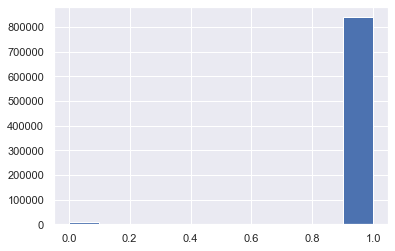

In [174]:
df_limpio['IND_CARTERA'].hist()

In [175]:
df_limpio.groupby('IND_CARTERA').size()

IND_CARTERA
0     10032
1    839174
dtype: int64

TODO ver si la conservamos o no.

Antes de pasar al estudio de variables categóricas, vamos a pasar a continuas las variables continuas que se estaban leyendo como categóricas, y analizarlas también.
Las columnas identificadas eran las siguientes:
* NUM_ANTIGUEDAD_POLIZA
* NUM_ANTI_MUTUALISTA
* EDAD
* NUM_ANTI_CARNET
* FACTOR_EXPERIAN
* IMP_ANUALIDAD_ANTERIOR
* IMP_PRIMA_TARIFICADOR_RENOVACION
* PORC_REGULADOR
* IMP_DIFERENCIA
* IMP_PRIMA_RENOV_FINAL
* NUM_BONUS_ANTERIOR
* NUM_BONUS_ACTUAL
* NUM_ANTI_MATRICULA 
* IMP_VALOR_VEHICULO
* IMPORTE_TOTAL_DESCUENTO
* IMP_DESC_EMPLEADOS_TOTAL
* IMP_DESC_COMERCIAL_TOTAL
* IMP_DESC_PRECAMPANA
* IMP_DESC_CAMPANA 
* IMP_DESC_ESPECIAL
* IMP_DESC_BOLSA_RETENCION
* IMP_DESC_REGULADOR
* IMP_PRECAM_BUEN_MUTUALISTA
* IMP_PRECAM_NUEVO_VEHICULO
* IMP_PRECAM_MULTIPACK
* IMP_DESC_EMPLEADOS 
* IMP_CAMP_EMPL_COLABORADOR
* IMP_CAMPANA_PROV
* IMP_CAMP_MOTOS50 
* IMP_CAMP_MUTUALISTA_PROPIETARIO
* IMP_CAMP_DESC_ESPECIAL
* GASTO_TOTAL
* GASTO_TOTAL_ACTUAL

Vamos a generar la lista de columnas, para recorrerlas cambiando al formato adecuado.

In [176]:
columnas_a_formatear =['NUM_ANTIGUEDAD_POLIZA','NUM_ANTI_MUTUALISTA','EDAD','NUM_ANTI_CARNET','FACTOR_EXPERIAN',
'IMP_ANUALIDAD_ANTERIOR','IMP_PRIMA_TARIFICADOR_RENOVACION','PORC_REGULADOR','IMP_DIFERENCIA','IMP_PRIMA_RENOV_FINAL',
'NUM_BONUS_ANTERIOR','NUM_BONUS_ACTUAL','NUM_ANTI_MATRICULA','IMP_VALOR_VEHICULO','IMPORTE_TOTAL_DESCUENTO',
'IMP_DESC_EMPLEADOS_TOTAL','IMP_DESC_COMERCIAL_TOTAL','IMP_DESC_PRECAMPANA','IMP_DESC_CAMPANA','IMP_DESC_ESPECIAL',
'IMP_DESC_BOLSA_RETENCION','IMP_DESC_REGULADOR','IMP_PRECAM_BUEN_MUTUALISTA','IMP_PRECAM_NUEVO_VEHICULO',
'IMP_PRECAM_MULTIPACK','IMP_DESC_EMPLEADOS','IMP_CAMP_EMPL_COLABORADOR','IMP_CAMPANA_PROV','IMP_CAMP_MOTOS50',
'IMP_CAMP_MUTUALISTA_PROPIETARIO','IMP_CAMP_DESC_ESPECIAL','GASTO_TOTAL','GASTO_TOTAL_ACTUAL']

In [177]:
#dfInfoCodigoPostal['IMP_CAMP_DESC_ESPECIAL'] = dfInfoCodigoPostal['IMP_CAMP_DESC_ESPECIAL'].map(lambda x: float(x.strip().replace(',','.')))

In [178]:
dfColumnasLimpias = df_limpio.copy()
for i in columnas_a_formatear:
    try:
        dfColumnasLimpias[i] = dfColumnasLimpias[i].map(lambda x: float(x.strip().replace(',','.')))
        print("Formateada la columna", i)
    except:
        print("No se ha podido formatear la columna",i)

Formateada la columna NUM_ANTIGUEDAD_POLIZA
Formateada la columna NUM_ANTI_MUTUALISTA
Formateada la columna EDAD
Formateada la columna NUM_ANTI_CARNET
Formateada la columna FACTOR_EXPERIAN
Formateada la columna IMP_ANUALIDAD_ANTERIOR
Formateada la columna IMP_PRIMA_TARIFICADOR_RENOVACION
Formateada la columna PORC_REGULADOR
Formateada la columna IMP_DIFERENCIA
Formateada la columna IMP_PRIMA_RENOV_FINAL
Formateada la columna NUM_BONUS_ANTERIOR
Formateada la columna NUM_BONUS_ACTUAL
Formateada la columna NUM_ANTI_MATRICULA
Formateada la columna IMP_VALOR_VEHICULO
Formateada la columna IMPORTE_TOTAL_DESCUENTO
Formateada la columna IMP_DESC_EMPLEADOS_TOTAL
Formateada la columna IMP_DESC_COMERCIAL_TOTAL
Formateada la columna IMP_DESC_PRECAMPANA
Formateada la columna IMP_DESC_CAMPANA
Formateada la columna IMP_DESC_ESPECIAL
Formateada la columna IMP_DESC_BOLSA_RETENCION
Formateada la columna IMP_DESC_REGULADOR
Formateada la columna IMP_PRECAM_BUEN_MUTUALISTA
Formateada la columna IMP_PRECAM_

Parece que ha salido bien, analicemos ahora estas columnas.

In [179]:
"""
plt.figure(figsize=(15,500))
for i, var in enumerate(np.sort(columnas_a_formatear)):
    plt.subplot(dfColumnasLimpias.columns.shape[0],2,2*i+1)
    plt.hist(dfInfoCodigoPostal[var], bins = 20)
    plt.xlabel('')
    plt.title(var)
    plt.subplot(dfColumnasLimpias.columns.shape[0],2,2*i+2)
    plt.boxplot(dfColumnasLimpias[var], vert=False)
    plt.xlabel('')
    plt.title(var)"""

"\nplt.figure(figsize=(15,500))\nfor i, var in enumerate(np.sort(columnas_a_formatear)):\n    plt.subplot(dfColumnasLimpias.columns.shape[0],2,2*i+1)\n    plt.hist(dfInfoCodigoPostal[var], bins = 20)\n    plt.xlabel('')\n    plt.title(var)\n    plt.subplot(dfColumnasLimpias.columns.shape[0],2,2*i+2)\n    plt.boxplot(dfColumnasLimpias[var], vert=False)\n    plt.xlabel('')\n    plt.title(var)"

Aparte, hay campos flag que tienen 1 o 0, pero los toma como strings. Vamos a hacer la misma operación. Los campos son los siguientes:
* 'FLG_CONDUCTOR_HAB'
* 'FLG_BUEN_MUTUALISTA'
* 'FLG_VEHICULO_NUEVO'
* 'FLG_RECARGO_CONDUCTOR_DANOS'
* 'FLG_DESC_PRECAMPANA'
* 'FLG_DESC_ESPECIAL'
* 'FLG_DESC_BOLSA_RETENCION'
* 'FLG_DESC_REGULADOR', 
* 'FLG_PRECAM_BUEN_MUTUALISTA', 
* 'FLG_PRECAM_NUEVO_VEHICULO', 
* 'FLG_PRECAM_MULTIPACK', 
* 'FLG_CAMPANA_EMPLEADOS', 
* 'FLG_CAMP_EMPL_COLABORADOR', 
* 'FLG_CAMPANA_PROV',
* 'FLG_CAMP_MOTOS50',
* 'FLG_CAMP_MUTUALISTA_PROPIETARIO',
* 'FLG_CAMP_DESC_ESPECIAL'

In [180]:
columnas_flag =['FLG_CONDUCTOR_HAB', 'FLG_BUEN_MUTUALISTA', 'FLG_VEHICULO_NUEVO', 'FLG_RECARGO_CONDUCTOR_DANOS',
'FLG_DESC_PRECAMPANA', 'FLG_DESC_ESPECIAL', 'FLG_DESC_BOLSA_RETENCION', 'FLG_DESC_REGULADOR', 'FLG_PRECAM_BUEN_MUTUALISTA',
'FLG_PRECAM_NUEVO_VEHICULO', 'FLG_PRECAM_MULTIPACK', 'FLG_CAMPANA_EMPLEADOS', 'FLG_CAMP_EMPL_COLABORADOR',
'FLG_CAMPANA_PROV', 'FLG_CAMP_MOTOS50', 'FLG_CAMP_MUTUALISTA_PROPIETARIO', 'FLG_CAMP_DESC_ESPECIAL','FLG_DESC_CAMPANA']

In [181]:
for i in columnas_flag:
    try:
        dfColumnasLimpias[i] = dfColumnasLimpias[i].map(lambda x: int(x.strip().replace(',','')))
        print("Formateada la columna ", i)
    except:
        print("No se ha podido formatear la columana ",i)

No se ha podido formatear la columana  FLG_CONDUCTOR_HAB
No se ha podido formatear la columana  FLG_BUEN_MUTUALISTA
No se ha podido formatear la columana  FLG_VEHICULO_NUEVO
Formateada la columna  FLG_RECARGO_CONDUCTOR_DANOS
Formateada la columna  FLG_DESC_PRECAMPANA
Formateada la columna  FLG_DESC_ESPECIAL
Formateada la columna  FLG_DESC_BOLSA_RETENCION
Formateada la columna  FLG_DESC_REGULADOR
Formateada la columna  FLG_PRECAM_BUEN_MUTUALISTA
Formateada la columna  FLG_PRECAM_NUEVO_VEHICULO
Formateada la columna  FLG_PRECAM_MULTIPACK
Formateada la columna  FLG_CAMPANA_EMPLEADOS
Formateada la columna  FLG_CAMP_EMPL_COLABORADOR
Formateada la columna  FLG_CAMPANA_PROV
Formateada la columna  FLG_CAMP_MOTOS50
Formateada la columna  FLG_CAMP_MUTUALISTA_PROPIETARIO
Formateada la columna  FLG_CAMP_DESC_ESPECIAL
Formateada la columna  FLG_DESC_CAMPANA


Veamos que pasa con estas tres:

In [182]:
dfColumnasLimpias.groupby('FLG_CONDUCTOR_HAB').size()

FLG_CONDUCTOR_HAB
N     97712
S    751493
dtype: int64

Simplemente en vez de 0 y 1 tiene N y S. Lo podemos cambiar para que sea coherente con el resto de campos Flag.

In [183]:
dfColumnasLimpias.groupby('FLG_BUEN_MUTUALISTA').size()

FLG_BUEN_MUTUALISTA
0     389120
0     444989
NO     12335
SI      2762
dtype: int64

Hay ceros y hay sies y noes.

In [184]:
dfColumnasLimpias.groupby('FLG_VEHICULO_NUEVO').size()

FLG_VEHICULO_NUEVO
0     824626
NO     23876
SI       704
dtype: int64

Hay ceros y hay sies y noes


In [185]:
dfColumnasLimpias['FLG_CONDUCTOR_HAB']=dfColumnasLimpias['FLG_CONDUCTOR_HAB'].map(lambda x: 1 if x=='S' else 0)
dfColumnasLimpias['FLG_BUEN_MUTUALISTA']=dfColumnasLimpias['FLG_BUEN_MUTUALISTA'].map(lambda x: 1 if x=='SI' else 0)
dfColumnasLimpias['FLG_VEHICULO_NUEVO']=dfColumnasLimpias['FLG_VEHICULO_NUEVO'].map(lambda x: 1 if x=='SI' else 0)

In [186]:
dfColumnasLimpias.groupby('FLG_CONDUCTOR_HAB').size()

FLG_CONDUCTOR_HAB
0     97713
1    751493
dtype: int64

In [187]:
dfColumnasLimpias.groupby('FLG_BUEN_MUTUALISTA').size()

FLG_BUEN_MUTUALISTA
0    846444
1      2762
dtype: int64

In [188]:
dfColumnasLimpias.groupby('FLG_VEHICULO_NUEVO').size()

FLG_VEHICULO_NUEVO
0    848502
1       704
dtype: int64

#### Variables categóricas
Veamos cuantas variables categóricas quedan.

In [189]:
filteredColumns = dfColumnasLimpias.dtypes[dfColumnasLimpias.dtypes == np.object]
listOfColumnNames = list(filteredColumns.index)
print(listOfColumnNames)

['TIPO_OPERACION', 'DES_FORMA_CONTRATA', 'DES_FORMA_PAGO', 'DES_MODO_PAGO', 'DES_BANCO', 'COD_MODALIDAD_ANT', 'COD_MODALIDAD_REG', 'COD_MODALIDAD_ACT', 'VAL_MUT_G', 'VAL_MUT_5', 'VAL_MUT_1', 'COD_ZONA_TARIFA', 'NOTABUREAU', 'NOTAGLOBAL', 'NOTA_FACTOR_EXPERIAN', 'COD_REGULADOR', 'DES_TRAMO_BONUS', 'DESC_OFICINA_GESTORA', 'DESC_OFICINA_ABRIDORA', 'DES_TIPO_CLIENTE', 'ID_REL_PROFESION', 'DESC_TITULACION', 'DESC_PROFESION', 'DES_TIPO_SINIESTRO', 'DESC_TIPO_VEHICULO', 'DESC_GRUPO_TARIFICACION', 'COD_REMOLQUE', 'DESC_MARCA', 'DESC_MODELO_VERSION', 'COD_COMBUSTIBLE', 'NUM_PUERTAS', 'COD_TIPO_BOLSA_DESCUENTO']


In [190]:
for var in listOfColumnNames:
    categorias = dfColumnasLimpias[var].unique()
    num_categorias = len(categorias)
    print('Categorías de', var, ':',categorias)
    print('Categorías distintas:',num_categorias)

Categorías de TIPO_OPERACION : ['RENOR' 'REH_CART' 'RENONR' 'SUPLR' 'BAJA' 'SUPLCA' 'SUPLRNP' 'EMIS'
 'SUPL' 'REHAB' 'RENOR     ' 'SUSP']
Categorías distintas: 12
Categorías de DES_FORMA_CONTRATA : ['Anual renovable' 'Temporal de ajuste Remolques' 'No Informado']
Categorías distintas: 3
Categorías de DES_FORMA_PAGO : ['Anual' 'Semestral' 'Trimestral' 'Unica' 'Semestral sin recargo'
 'Trimestral sin recargo' 'No Informado']
Categorías distintas: 7
Categorías de DES_MODO_PAGO : ['Por Banco' 'Por Caja' 'No Informado']
Categorías distintas: 3
Categorías de DES_BANCO : ['BANCO DE SABADELL S.A.' 'BANCO BILBAO VIZCAYA ARGENTARIA (BBVA)'
 'BANCO SANTANDER S.A.' 'BANCO MARE NOSTRUM S.A.' 'BARCLAYS BANK S.A'
 'BANCO ESPAÑOL DE CREDITO S.A.' 'No Informado'
 'C.A.DE CASTILLA LA MANCHA' 'CAIXABANK S.A.'
 'C.A. DE SALAMANCA Y SORIA (CAJA DUERO)' 'LIBERBANK S.A.'
 'KUTXABANK S.A.' 'CAJASIETE CAJA RURAL SDAD.COOP.CTO.'
 'ABANCA CORPORACION BANCARIA S.A.' 'BANKIA S.A.'
 'BANCO POPULAR ESPAÑOL S.A.' 'BA

Categorías de DES_TIPO_CLIENTE : ['6 - Familiar de Mutualista' '1 - Licenciado Sanitario' '5 - Empleado'
 '3 - Form. Profesional Sanitaria' '2 - Diplomado Sanitario'
 'S - Sociedad no Sanitaria' '9 - Familiar de no Mutualista'
 'E - Sociedad Sanitaria' 'A - Asesor' '4 - Estudiante Sanitario'
 'C - Colegio Profesional' 'No Informado']
Categorías distintas: 12
Categorías de ID_REL_PROFESION : ['2 - No Sanitaria' '1 - Sanitaria']
Categorías distintas: 2
Categorías de DESC_TITULACION : ['9 - OTRAS PROFESIONES' '1 - LICENCIADO SANITARIO'
 '2 - DIPLOMADO SANITARIO' '1 - Licenciado Sanitario' 'No Informada'
 '3 - FORM. PROFESIONAL SANITARIA' '2 - Diplomado Sanitario'
 '3 - T.AUXILIAR VETERINARIA']
Categorías distintas: 8
Categorías de DESC_PROFESION : ['11 - ARQUITECTO/A' '1 - MÉDICO' '3 - ODONTÓLOGO' '4 - VETERINARIO'
 '2 - FARMACÉUTICO' '16 - ADMINISTRATIVO' '0 - NO INFORMADO'
 '210 - PENSIONISTA' '14 - INGENIERO/A' '999 - DESCONOCIDA'
 '72 - JUBILADO/A' '17 - AMA DE CASA' '31 - D.ENFERMERI

Categorías de DESC_MARCA : ['SEAT' 'RENAULT' 'MINI' 'VOLKSWAGEN' 'MERCEDES-BENZ' 'MG' 'CITROEN'
 'BULTACO' 'PEUGEOT' 'JEEP' 'PORSCHE' 'VOLVO' 'VESPA' 'CHRYSLER' 'TRIUMPH'
 'FORD' 'SUZUKI' 'HYUNDAI' 'MONTESA' 'DUCATI' 'OPEL' 'JAGUAR' 'KIA'
 'LAND-ROVER' 'PIAGGIO' 'TOYOTA' 'SANGLAS' 'AUDI' 'HONDA' 'BMW' 'NISSAN'
 'FIAT' 'DAEWOO' 'MITSUBISHI' 'YAMAHA' 'LANCIA' 'APRILIA' 'TALBOT'
 'AUSTIN' 'AUTOBIANCHI' 'SUZUKI-SANTANA' 'BUICK' 'SKODA' 'DACIA' 'MAZDA'
 'FERRARI' 'SMART' 'MORRIS' 'SIMCA' 'DODGE' 'EBRO' 'ALFA ROMEO' 'PONTIAC'
 'CHEVROLET' 'ROVER' 'INNOCENTI' 'VESPINO' 'MOTO GUZZI' 'PUCH' 'SSANGYONG'
 'SUBARU' 'LEXUS' 'M.V.' 'HYOSUNG' 'ISUZU' 'DERBI' 'AUTOCARAVANAS'
 'MOBYLETTE' 'BENELLI' 'ROLLS-ROYCE' 'KYMCO' 'MZ' 'SANTANA' 'KAWASAKI'
 'SAAB' 'DAIHATSU' 'LADA / AUTOVAZ' 'DAIMLER' 'RANGE-ROVER' 'DAELIM'
 'CAGIVA' 'SYM' 'MORGAN' 'BERTONE' 'MAHINDRA' 'GALLOPER' 'HARLEY-DAVIDSON'
 'GAS GAS' 'OSSA' 'BIMOTA' 'UAZ' 'GILERA' 'MBK' 'CADILLAC' 'INFINITI'
 'MALAGUTI' 'RIEJU' 'MICROCOCHE' 'CICLOMOTOR' '

Vamos una a una
#### TIPO_OPERACION

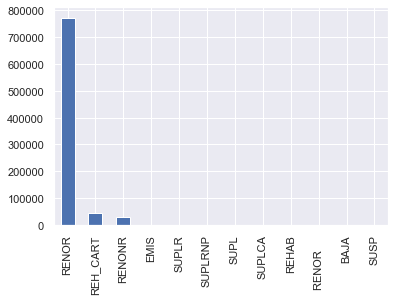

In [191]:
dfColumnasLimpias['TIPO_OPERACION'].value_counts().plot(kind='bar')


In [192]:
dfColumnasLimpias['TIPO_OPERACION'].value_counts()

RENOR         771806
REH_CART       44550
RENONR         30742
EMIS             991
SUPLR            444
SUPLRNP          438
SUPL              97
SUPLCA            77
REHAB             28
RENOR             25
BAJA               6
SUSP               2
Name: TIPO_OPERACION, dtype: int64

In [193]:
dfColumnasLimpias.groupby(['TIPO_OPERACION', 'FLG_RENUEVA']).size()

TIPO_OPERACION  FLG_RENUEVA
BAJA            0                   6
EMIS            0                 990
                1                   1
REHAB           0                  28
REH_CART        0               44207
                1                 343
RENONR          0                2494
                1               28248
RENOR           0               51058
                1              720748
RENOR           1                  25
SUPL            0                  97
SUPLCA          0                  75
                1                   2
SUPLR           0                 378
                1                  66
SUPLRNP         0                 436
                1                   2
SUSP            0                   2
dtype: int64

TODO confirmar que es un falso predictor, nos lo cargamos

#### DES_FORMA_CONTRATA

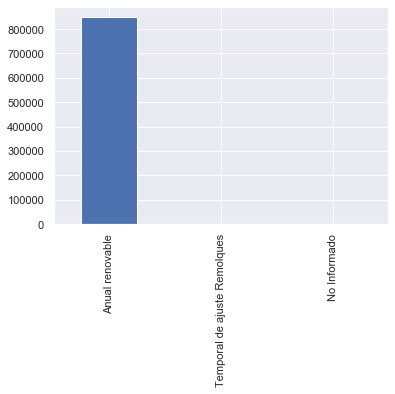

In [194]:
dfColumnasLimpias['DES_FORMA_CONTRATA'].value_counts().plot(kind='bar')


In [195]:
dfColumnasLimpias['DES_FORMA_CONTRATA'].value_counts()

Anual renovable                 849163
Temporal de ajuste Remolques        42
No Informado                         1
Name: DES_FORMA_CONTRATA, dtype: int64

Muy desbalanceada, apenas hay datos en el Temporal ajuste de remolques.
#### DES_FORMA_PAGO

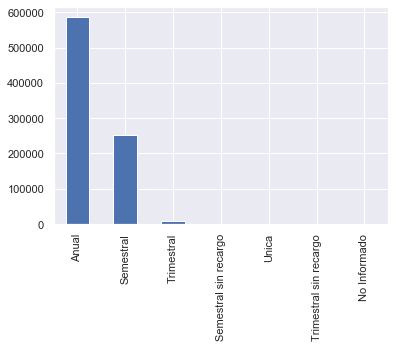

In [196]:
dfColumnasLimpias['DES_FORMA_PAGO'].value_counts().plot(kind='bar')

In [197]:
dfColumnasLimpias['DES_FORMA_PAGO'].value_counts()

Anual                     586575
Semestral                 253265
Trimestral                  9335
Semestral sin recargo         26
Unica                          3
Trimestral sin recargo         1
No Informado                   1
Name: DES_FORMA_PAGO, dtype: int64

#### DES_MODO_PAGO

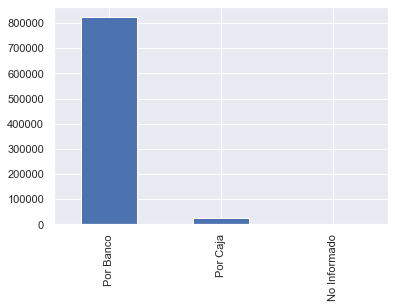

In [198]:
dfColumnasLimpias['DES_MODO_PAGO'].value_counts().plot(kind='bar')


In [199]:
dfColumnasLimpias['DES_MODO_PAGO'].value_counts()

Por Banco       822868
Por Caja         26337
No Informado         1
Name: DES_MODO_PAGO, dtype: int64

#### DES_BANCO

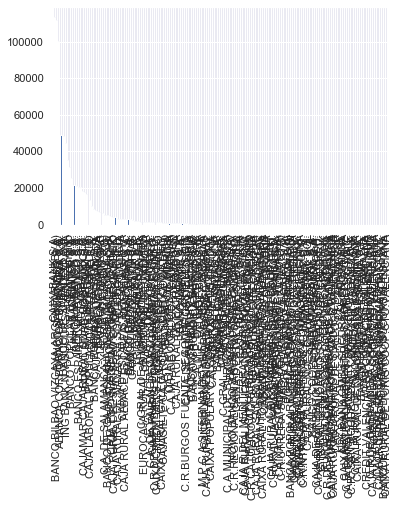

In [200]:
dfColumnasLimpias['DES_BANCO'].value_counts().plot(kind='bar')


In [201]:
dfColumnasLimpias['DES_BANCO'].value_counts()

CAIXABANK S.A.                              113127
BANCO BILBAO VIZCAYA ARGENTARIA (BBVA)      111529
BANCO SANTANDER S.A.                        100456
ABANCA CORPORACION BANCARIA S.A.             48801
BANKIA S.A.                                  48423
BANCO DE SABADELL S.A.                       44780
ING BANK N.V.SUCURSAL EN ESPAÑA              35134
No Informado                                 31350
BANCO POPULAR ESPAÑOL S.A.                   25249
BANKINTER S.A.                               21785
UNICAJA BANCO S.A.                           21249
IBERCAJA BANCO S.A.                          20702
BANCO ESPAÑOL DE CREDITO S.A.                20584
KUTXABANK S.A.                               18425
CAJAMAR CAJA RURAL SDAD.COOP.DE CTO.         17854
BANCO MARE NOSTRUM S.A.                      16835
LIBERBANK S.A.                               13247
CAJA LABORAL POPULAR COOP.DE CREDITO         10259
CAJASUR BANCO S.A.                            8411
BANCO POPULAR PASTOR S.A.      

Este campo tiempo tiene demasiados casos. Hay que ver si se pueden agrupar estos datos de alguna manera, por ejemplo, bancos que ofrecen servicios de aseguradora o no.

#### COD_MODALIDAD_ANT

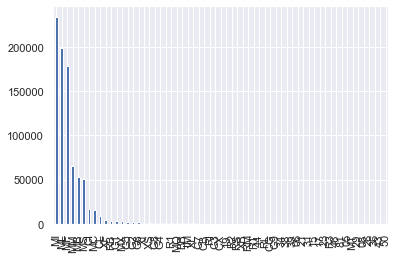

In [202]:
dfColumnasLimpias['COD_MODALIDAD_ANT'].value_counts().plot(kind='bar')

In [203]:
dfColumnasLimpias['COD_MODALIDAD_ANT'].value_counts()

MI    234428
ML    198498
MF    178358
MM     65100
MB     53346
MS     50887
CI     16637
MC     15225
CL      8582
XF      3850
RB      3179
G1      3069
MX      2952
G5      2464
G2      1586
G6      1574
XI      1370
XS      1050
G8      1021
G4       906
         882
R1       746
MQ       655
BB       589
IM       479
XL       367
G7       276
CB       217
RI       181
G3       134
CX        64
19        60
R2        53
RS        44
XB        44
RM        41
RT        41
44        37
RL        30
CG        25
G9        24
34        22
38        18
39        11
06        10
21        10
31         8
15         7
17         6
23         6
R3         6
46         6
81         5
05         3
MT         3
29         3
08         3
26         3
36         2
43         2
50         1
Name: COD_MODALIDAD_ANT, dtype: int64

TODO ver qué es esto
#### COD_MODALIDAD_REG

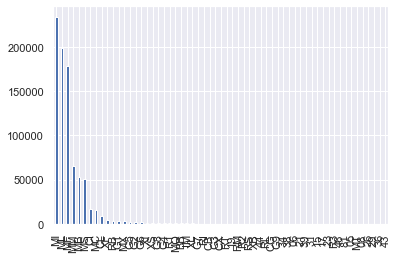

In [204]:
dfColumnasLimpias['COD_MODALIDAD_REG'].value_counts().plot(kind='bar')


In [205]:
dfColumnasLimpias['COD_MODALIDAD_REG'].value_counts()

MI    233892
ML    198486
MF    178497
MM     65102
MB     52566
MS     50931
CI     17079
MC     15225
CL      9033
XF      3985
RB      3620
G1      3105
MX      3072
G5      2486
G2      1620
G6      1585
XI      1435
XS      1119
G8      1027
G4       916
R1       744
MQ       655
BB       583
IM       497
XL       387
G7       280
RI       245
CB       236
G3       141
CX        73
RT        64
19        60
RM        56
R2        53
RS        52
XB        45
44        37
RL        35
CG        25
G9        24
34        22
38        18
06        10
21        10
39        10
31         8
15         7
17         6
23         6
R3         6
46         6
81         5
05         3
MT         3
08         3
26         3
29         3
36         2
43         2
Name: COD_MODALIDAD_REG, dtype: int64

TODO esto igual
#### COD_MODALIDAD_ACT

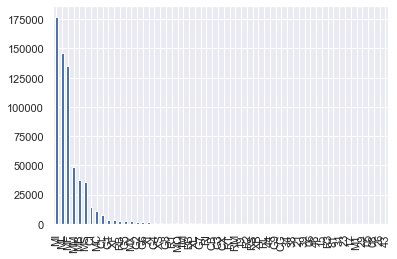

In [206]:
dfColumnasLimpias['COD_MODALIDAD_ACT'].value_counts().plot(kind='bar')


In [207]:
dfColumnasLimpias['COD_MODALIDAD_ACT'].value_counts()

MI    177148
ML    145692
MF    134641
MM     48310
MB     37809
MS     35632
CI     14529
MC     10986
CL      7365
G1      3527
XF      3255
RB      2672
G5      2478
MX      2264
G2      1862
G6      1525
XI      1163
G4      1070
XS       946
G8       882
R1       535
MQ       489
IM       417
BB       412
XL       302
G7       291
RI       191
CB       191
G3       144
CX        64
RT        49
RM        44
19        44
R2        38
RS        38
XB        34
RL        31
44        28
G9        20
CG        19
34        16
38        12
21         8
39         7
06         7
46         6
15         5
R3         4
81         4
31         4
23         4
17         4
MT         3
29         2
05         2
08         2
26         2
43         1
Name: COD_MODALIDAD_ACT, dtype: int64

In [208]:
dfColumnasLimpias.groupby(['COD_MODALIDAD_ACT', 'FLG_RENUEVA']).size()

COD_MODALIDAD_ACT  FLG_RENUEVA
05                 1                   2
06                 1                   7
08                 1                   2
15                 1                   5
17                 1                   4
19                 0                   6
                   1                  38
21                 0                   1
                   1                   7
23                 1                   4
26                 1                   2
29                 1                   2
31                 1                   4
34                 0                   1
                   1                  15
38                 0                   2
                   1                  10
39                 1                   7
43                 0                   1
44                 1                  28
46                 1                   6
81                 0                   1
                   1                   3
BB                 0      

TODO igual
#### VAL_MUT_G

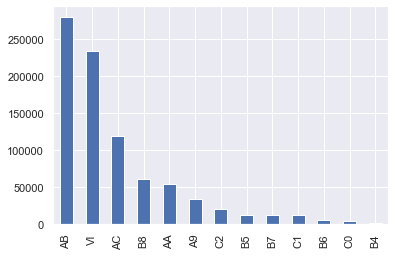

In [209]:
dfColumnasLimpias['VAL_MUT_G'].value_counts().plot(kind='bar')


In [210]:
dfColumnasLimpias['VAL_MUT_G'].value_counts()

AB    280208
VI    234657
AC    119297
B8     60527
AA     54631
A9     34094
C2     20731
B5     12215
B7     11708
C1     11594
B6      5072
C0      3834
B4       638
Name: VAL_MUT_G, dtype: int64

TODO ver qué es esto
#### VAL_MUT_5

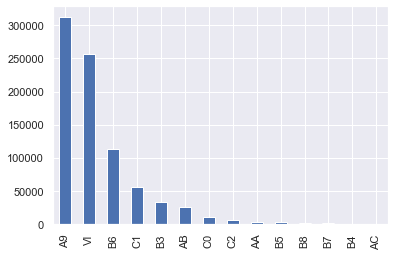

In [211]:
dfColumnasLimpias['VAL_MUT_5'].value_counts().plot(kind='bar')


In [212]:
dfColumnasLimpias['VAL_MUT_5'].value_counts()

A9    312930
VI    257243
B6    113750
C1     56193
B3     33270
AB     26047
C0     10303
C2      6181
AA      3328
B5      2990
B8       843
B7       732
B4       509
AC       484
Name: VAL_MUT_5, dtype: int64

TODO igual
#### VAL_MUT_1

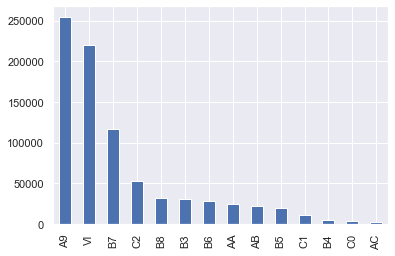

In [213]:
dfColumnasLimpias['VAL_MUT_1'].value_counts().plot(kind='bar')


In [214]:
dfColumnasLimpias['VAL_MUT_1'].value_counts()

A9    254821
VI    220124
B7    117269
C2     53182
B8     32118
B3     30376
B6     28526
AA     23953
AB     22654
B5     19296
C1     11234
B4      5185
C0      3519
AC      2546
Name: VAL_MUT_1, dtype: int64

TODO igual
#### COD_ZONA_TARIFA

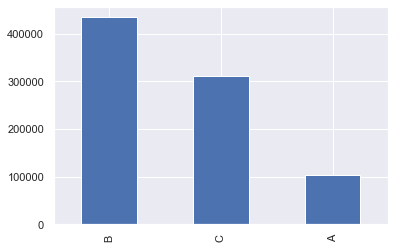

In [215]:
dfColumnasLimpias['COD_ZONA_TARIFA'].value_counts().plot(kind='bar')

In [216]:
dfColumnasLimpias['COD_ZONA_TARIFA'].value_counts()

B    434694
C    310377
A    104135
Name: COD_ZONA_TARIFA, dtype: int64

Tres categorías, las tres con una cantidad de datos relevante, se pueden pasar a one-hot tal cual
#### NOTABUREAU

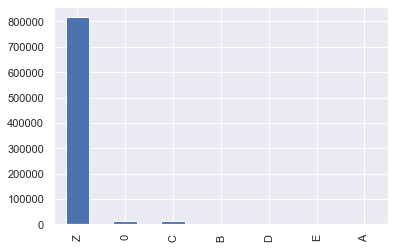

In [217]:
dfColumnasLimpias['NOTABUREAU'].value_counts().plot(kind='bar')


In [218]:
dfColumnasLimpias['NOTABUREAU'].value_counts()

Z    816696
0     14797
C     12015
B      2250
D      1838
E       177
A        47
Name: NOTABUREAU, dtype: int64

Casi todas las entradas toman el mismo valor, hay que ver si se elimina la columna
TODO ver correlación entre el campo y el target
#### NOTAGLOBAL

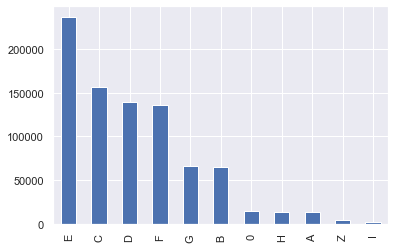

In [219]:
dfColumnasLimpias['NOTAGLOBAL'].value_counts().plot(kind='bar')


In [220]:
dfColumnasLimpias['NOTAGLOBAL'].value_counts()

E    236971
C    156605
D    139548
F    135966
G     65914
B     64826
0     14797
H     13563
A     13199
Z      4021
I      2410
Name: NOTAGLOBAL, dtype: int64

TODO Ver si se agrupan, se elimina la columna o se pasa a one hot tal cual
#### NOTA_FACTOR_EXPERIAN

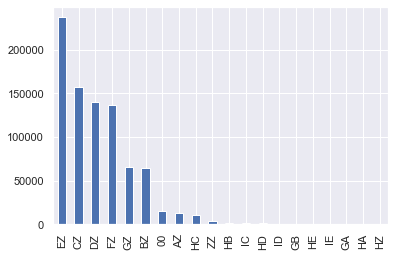

In [221]:
dfColumnasLimpias['NOTA_FACTOR_EXPERIAN'].value_counts().plot(kind='bar')


In [222]:
dfColumnasLimpias['NOTA_FACTOR_EXPERIAN'].value_counts()

EZ    236971
CZ    156605
DZ    139548
FZ    135966
GZ     65557
BZ     64826
00     14797
AZ     13199
HC     10259
ZZ      4021
HB      1933
IC      1756
HD      1272
ID       566
GB       317
HE        89
IE        88
GA        40
HA         7
HZ         3
Name: NOTA_FACTOR_EXPERIAN, dtype: int64

In [223]:
dfColumnasLimpias.groupby(["NOTA_FACTOR_EXPERIAN","NOTAGLOBAL","NOTABUREAU"]).size()

NOTA_FACTOR_EXPERIAN  NOTAGLOBAL  NOTABUREAU
00                    0           0              14797
AZ                    A           Z              13199
BZ                    B           Z              64826
CZ                    C           Z             156605
DZ                    D           Z             139548
EZ                    E           Z             236971
FZ                    F           Z             135966
GA                    G           A                 40
GB                    G           B                317
GZ                    G           Z              65557
HA                    H           A                  7
HB                    H           B               1933
HC                    H           C              10259
HD                    H           D               1272
HE                    H           E                 89
HZ                    H           Z                  3
IC                    I           C               1756
ID                  

Se puede eliminar esta columna al ser una concatenación de las dos anteriores
#### COD_REGULADOR

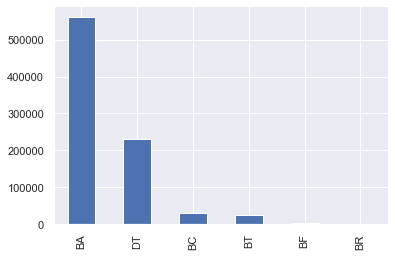

In [224]:
dfColumnasLimpias['COD_REGULADOR'].value_counts().plot(kind='bar')


In [225]:
dfColumnasLimpias['COD_REGULADOR'].value_counts()

BA    561937
DT    230371
BC     30955
BT     24398
BF      1541
BR         2
Name: COD_REGULADOR, dtype: int64

TODO BR tiene muy pocos datos
#### DES_TRAMO_BONUS

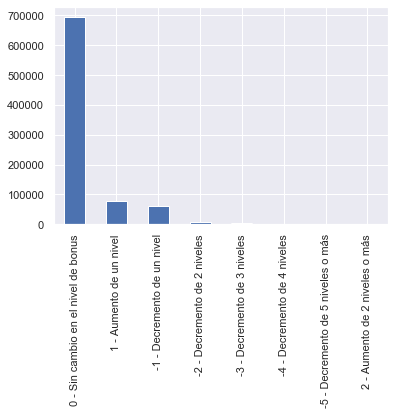

In [226]:
dfColumnasLimpias['DES_TRAMO_BONUS'].value_counts().plot(kind='bar')


In [227]:
dfColumnasLimpias['DES_TRAMO_BONUS'].value_counts()

0 - Sin cambio en el nivel de bonus    694285
1 - Aumento de un nivel                 79085
-1 - Decremento de un nivel             61446
-2 - Decremento de 2 niveles             8758
-3 - Decremento de 3 niveles             2323
-4 - Decremento de 4 niveles             2249
-5 - Decremento de 5 niveles o más        669
2 - Aumento de 2 niveles o más            391
Name: DES_TRAMO_BONUS, dtype: int64

TODO Es una agrupación de una continua, hay que ver si tomamos esta o la continua
#### DESC_OFICINA_GESTORA

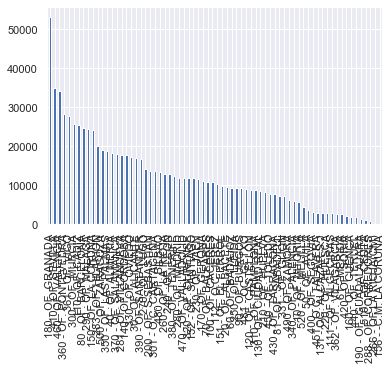

In [228]:
dfColumnasLimpias['DESC_OFICINA_GESTORA'].value_counts().plot(kind='bar')

In [229]:
dfColumnasLimpias['DESC_OFICINA_GESTORA'].value_counts()

180 - OF. GRANADA        53116
410 - OF. SEVILLA        34969
460 - OF. VALENCIA       34008
360 - OF. PONTEVEDRA     28163
361 - OF. VIGO           27749
300 - OF. MURCIA         25598
110 - OF. CADIZ          25383
80 - OF. BARCELONA       24670
290 - OF. MALAGA         24226
150 - OF. LA CORUÑA      24138
283 - OF. HILARION       20066
500 - OF. ZARAGOZA       18927
350 - OF. LAS PALMAS     18603
40 - OF. ALMERIA         18154
370 - OF. SALAMANCA      17854
281 - OF. VILLANUEVA     17743
140 - OF. CORDOBA        17654
330 - OF. OVIEDO         17156
30 - OF. ALICANTE        16824
390 - OF. SANTANDER      16781
270 - OF. LUGO           14010
200 - OF. S.SEBASTIAN    13642
301 - O.C. CARTAGENA     13547
480 - OF. BILBAO         13427
260 - OF. LA RIOJA       12928
240 - OF. LEON           12757
380 - OF. TENERIFE       12412
280 - OF. MADRID         11904
470 - OF. VALLADOLID     11852
320 - OF. OURENSE        11720
152 - OF. SANTIAGO       11688
230 - OF. JAEN           11410
170 - OF

TODO Hay muchísimos, de momento se quitará
#### DESC_OFICINA_ABRIDORA

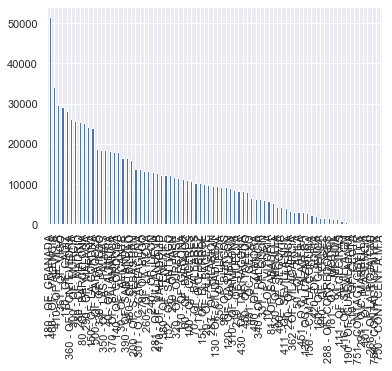

In [230]:
dfColumnasLimpias['DESC_OFICINA_ABRIDORA'].value_counts().plot(kind='bar')

In [231]:
dfColumnasLimpias['DESC_OFICINA_ABRIDORA'].value_counts()

180 - OF. GRANADA        51599
460 - OF. VALENCIA       34004
410 - OF. SEVILLA        29745
361 - OF. VIGO           29116
110 - OF. CADIZ          28105
360 - OF. PONTEVEDRA     26249
300 - OF. MURCIA         25747
280 - OF. MADRID         25514
80 - OF. BARCELONA       25085
290 - OF. MALAGA         24088
150 - OF. LA CORUÑA      23951
500 - OF. ZARAGOZA       18720
330 - OF. OVIEDO         18462
350 - OF. LAS PALMAS     18328
40 - OF. ALMERIA         18115
370 - OF. SALAMANCA      17931
140 - OF. CORDOBA        17903
30 - OF. ALICANTE        16501
390 - OF. SANTANDER      16416
480 - OF. BILBAO         16014
200 - OF. S.SEBASTIAN    13699
301 - O.C. CARTAGENA     13585
270 - OF. LUGO           13134
260 - OF. LA RIOJA       13129
240 - OF. LEON           12910
281 - OF. VILLANUEVA     12753
470 - OF. VALLADOLID     12264
380 - OF. TENERIFE       12193
152 - OF. SANTIAGO       12150
230 - OF. JAEN           11808
320 - OF. OURENSE        11566
170 - OF. GERONA         11103
60 - OF.

TODO Demasiadas oficinas, además de que la abridora no es la más relevante
#### DES_TIPO_CLIENTE

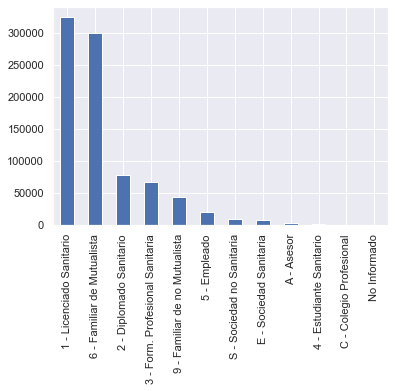

In [232]:
dfColumnasLimpias['DES_TIPO_CLIENTE'].value_counts().plot(kind='bar')

In [233]:
dfColumnasLimpias['DES_TIPO_CLIENTE'].value_counts()

1 - Licenciado Sanitario           323748
6 - Familiar de Mutualista         299742
2 - Diplomado Sanitario             78077
3 - Form. Profesional Sanitaria     65992
9 - Familiar de no Mutualista       42743
5 - Empleado                        20163
S - Sociedad no Sanitaria            8001
E - Sociedad Sanitaria               7027
A - Asesor                           2328
4 - Estudiante Sanitario             1310
C - Colegio Profesional                70
No Informado                            5
Name: DES_TIPO_CLIENTE, dtype: int64

TODO Podemos usar esta o usar la siguiente, que divide en sanitarios o no

#### ID_REL_PROFESION

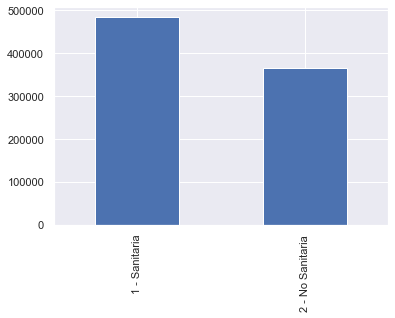

In [234]:
dfColumnasLimpias['ID_REL_PROFESION'].value_counts().plot(kind='bar')

In [235]:
dfColumnasLimpias['ID_REL_PROFESION'].value_counts()

1 - Sanitaria       483635
2 - No Sanitaria    365571
Name: ID_REL_PROFESION, dtype: int64

TODO De momento usaremos esta
#### DESC_TITULACION

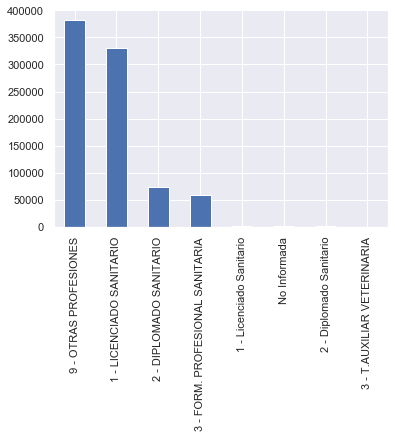

In [236]:
dfColumnasLimpias['DESC_TITULACION'].value_counts().plot(kind='bar')

In [237]:
dfColumnasLimpias['DESC_TITULACION'].value_counts()

9 - OTRAS PROFESIONES              383058
1 - LICENCIADO SANITARIO           330470
2 - DIPLOMADO SANITARIO             73158
3 - FORM. PROFESIONAL SANITARIA     58841
1 - Licenciado Sanitario             1684
No Informada                         1163
2 - Diplomado Sanitario               820
3 - T.AUXILIAR VETERINARIA             12
Name: DESC_TITULACION, dtype: int64

TODO Más información redundante
#### DESC_PROFESION

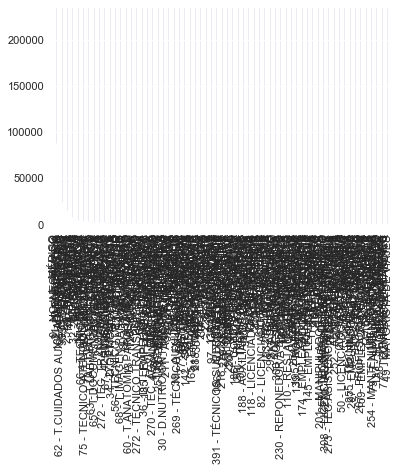

In [238]:
dfColumnasLimpias['DESC_PROFESION'].value_counts().plot(kind='bar')

In [239]:
dfColumnasLimpias['DESC_PROFESION'].value_counts()

1 - MÉDICO                              224276
0 - NO INFORMADO                         87644
31 - D.ENFERMERIA                        62972
2 - FARMACÉUTICO                         55299
16 - ADMINISTRATIVO                      47696
62 - T.CUIDADOS AUXILIARES ENFERMER      30168
4 - VETERINARIO                          24343
3 - ODONTÓLOGO                           19853
999 - DESCONOCIDA                        19707
72 - JUBILADO/A                          19318
23 - EMPRESARIO                          15832
25 - FUNCIONARIO/A                       12439
29 - PROFESOR/A                          10751
17 - AMA DE CASA                          9137
14 - INGENIERO/A                          8419
31 - ABOGADO/A                            7821
92 - COMERCIAL                            6222
32 - D.FISIOTERAPIA                       5527
20 - ESTUDIANTE                           5014
286 - OPERARIO                            4756
8 - PSICOLOGO                             4546
15 - INFORMÁT

TODO Demasiados campos no agrupados, tiene más sentido tomar alguna de las columnas anteriores que hacen alusión al empleo del asegurado 
#### DES_TIPO_SINIESTRO

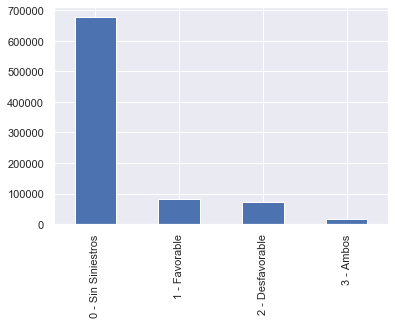

In [240]:
dfColumnasLimpias['DES_TIPO_SINIESTRO'].value_counts().plot(kind='bar')

In [241]:
dfColumnasLimpias['DES_TIPO_SINIESTRO'].value_counts()

0 - Sin Siniestros    678581
1 - Favorable          81169
2 - Desfavorable       72248
3 - Ambos              17208
Name: DES_TIPO_SINIESTRO, dtype: int64

TODO Esta se puede pasar a One Hot tal cual
#### DESC_TIPO_VEHICULO

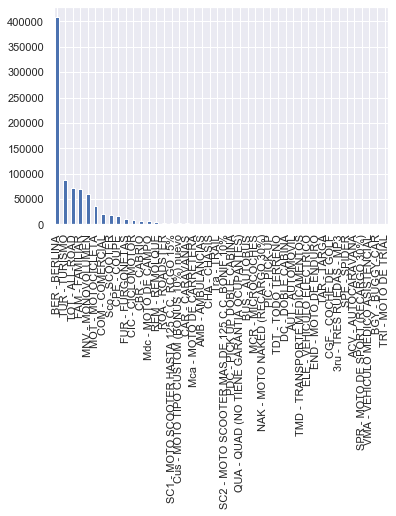

In [242]:
dfColumnasLimpias['DESC_TIPO_VEHICULO'].value_counts().plot(kind='bar')

In [243]:
dfColumnasLimpias['DESC_TIPO_VEHICULO'].value_counts()

BER - BERLINA                                   408047
TUR - TURISMO                                    88143
TOT - ALL-ROAD                                   71667
FAM - FAMILIAR                                   68937
MNV - MONOVOLUMEN                                59546
MOT - MOTOCICLETA                                36497
COM - COMERCIAL                                  21316
Sco - SCOOTER                                    19430
CPE - COUPE                                      17352
FUR - FURGONETAS                                 10191
CIC - CICLOMOTOR                                  7910
CBR - CABRIO                                      7493
Mdc - MOTO DE CAMPO                               7317
REM - REMOLQUE                                    3848
ROA - ROADSTER                                    3417
SC1 - MOTO SCOOTER HASTA 125 C.C. RCGO 15%        3100
Cus - MOTO TIPO CUSTOM (BONUS 10%) nuevo          2333
CAR - CARAVANAS                                   2074
Mca - MOTO

TODO Hay demasiadas, igual hay que agrupar en coche, motos, y otros
#### DESC_GRUPO_TARIFICACION

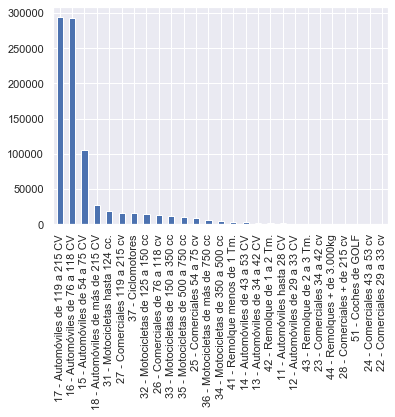

In [244]:
dfColumnasLimpias['DESC_GRUPO_TARIFICACION'].value_counts().plot(kind='bar')

In [245]:
dfColumnasLimpias['DESC_GRUPO_TARIFICACION'].value_counts()

17 - Automóviles de 119 a 215 CV      294012
16 - Automóviles de 76 a 118 CV       292716
15 - Automóviles de 54 a 75 CV        106012
18 - Automóviles de más de 215 CV      27520
31 - Motocicletas hasta 124 cc.        18816
27 - Comerciales 119 a 215 cv          15521
37 - Ciclomotores                      15434
32 - Motocicletas de 125 a 150 cc      14576
26 - Comerciales de 76 a 118 cv        12524
33 - Motocicletas de 150 a 350 cc      11671
35 - Motocicletas de 500 a 750 cc       9949
25 - Comerciales 54 a 75 cv             8399
36 - Motocicletas de más de 750 cc      6310
34 - Motocicletas de 350 a 500 cc       4682
41 - Remolque menos de 1 Tm.            3437
14 - Automóviles de 43 a 53 CV          3112
13 - Automóviles de 34 a 42 CV          1568
42 - Remolque de 1 a 2 Tm.              1233
11 - Automóviles hasta 28 CV             989
12 - Automóviles de 29 a 33 CV           391
43 - Remolque de 2 a 3 Tm.               171
23 - Comerciales 34 a 42 cv               54
44 - Remol

TODO Demasiadas categorías  
#### COD_REMOLQUE

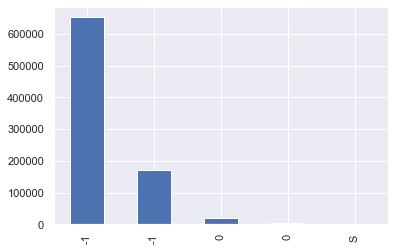

In [246]:
dfColumnasLimpias['COD_REMOLQUE'].value_counts().plot(kind='bar')

In [247]:
dfColumnasLimpias['COD_REMOLQUE'].value_counts()

-1    652336
-1    171460
0      20742
0       4437
S        231
Name: COD_REMOLQUE, dtype: int64

TODO Hay dos tipos de -1, dos tipos de 0, y una S con muy pocos datos. Hay que unificar los -1s y los 0s

In [248]:
dfColumnasLimpias['COD_REMOLQUE']= dfColumnasLimpias['COD_REMOLQUE'].map(lambda x: 1 if str(x).strip()=='0' else 0)

In [249]:
dfColumnasLimpias['COD_REMOLQUE'].value_counts()

0    824027
1     25179
Name: COD_REMOLQUE, dtype: int64

#### DESC_MARCA

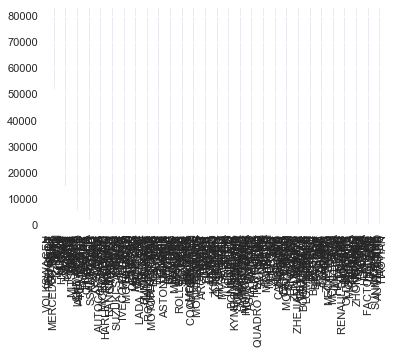

In [250]:
dfColumnasLimpias['DESC_MARCA'].value_counts().plot(kind='bar')

In [251]:
dfColumnasLimpias['DESC_MARCA'].value_counts()

VOLKSWAGEN         79550
PEUGEOT            60497
RENAULT            58793
SEAT               54929
CITROEN            54441
MERCEDES-BENZ      52156
FORD               48255
OPEL               43824
BMW                42463
AUDI               41254
TOYOTA             40292
HONDA              26349
NISSAN             25992
HYUNDAI            17336
FIAT               15672
SUZUKI             14586
KIA                13870
VOLVO              13658
YAMAHA             13340
PIAGGIO            10385
SKODA               8885
MAZDA               8855
MITSUBISHI          7975
DACIA               6638
MINI                5854
VESPA               5795
KYMCO               5454
CHEVROLET           4940
LAND-ROVER          4765
ALFA ROMEO          3878
REMOLQUE            3848
JEEP                3378
SMART               3351
LEXUS               3298
JAGUAR              3107
PORSCHE             2572
CHRYSLER            2279
APRILIA             2176
DAEWOO              2143
ROVER               2000


Demasiadas columnas, o se agrupan o se ignoran. 
#### DESC_MODELO_VERSION

In [252]:
dfColumnasLimpias['DESC_MODELO_VERSION'].value_counts().head()

Hasta 750 PMA. Y Hasta 8,5 MTS.    2518
Focus 1.6 Trend                    1608
Ibiza 1.9 SDi Stella               1431
A4 1.9TDI                          1422
Serie 3 E46 Die320d                1414
Name: DESC_MODELO_VERSION, dtype: int64

In [253]:
dfColumnasLimpias['DESC_MODELO_VERSION'].value_counts().count()

43088

Demasiadas columnas sin lugar a duda, podemos agrupar de alguna forma en el futuro, pero de momento fuera.
#### COD_COMBUSTIBLE

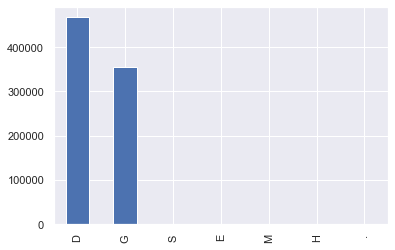

In [254]:
dfColumnasLimpias['COD_COMBUSTIBLE'].value_counts().plot(kind='bar')

In [255]:
dfColumnasLimpias['COD_COMBUSTIBLE'].value_counts()

D    467780
G    355063
S      1115
E       869
M       503
H         3
.         2
Name: COD_COMBUSTIBLE, dtype: int64

 Entre diesel y gasolina copan casi todo el conjunto de datos. 
 TODO ver aque se corresponden los dos ., y pasar a one hot.
#### NUM_PUERTAS

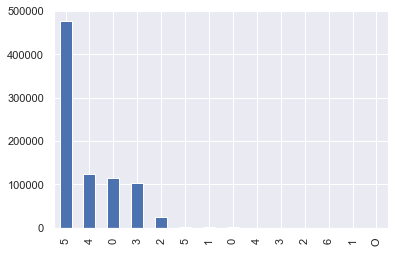

In [256]:
dfColumnasLimpias['NUM_PUERTAS'].value_counts().plot(kind='bar')

In [257]:
dfColumnasLimpias['NUM_PUERTAS'].value_counts()

5    477564
4    124096
0    114500
3    103050
2     24846
5      2455
1      1046
0       697
4       463
3       371
2       104
6         8
1         5
O         1
Name: NUM_PUERTAS, dtype: int64

Agrupa varios números varias veces, hay que limpiarlo si se quiere usar.

In [258]:
dfColumnasLimpias['NUM_PUERTAS'] = dfColumnasLimpias['NUM_PUERTAS'].map(lambda x: int(x) if str(x).isdigit() else 0)
dfColumnasLimpias['NUM_PUERTAS'].value_counts()

5    480019
4    124559
0    115198
3    103421
2     24950
1      1051
6         8
Name: NUM_PUERTAS, dtype: int64

#### COD_TIPO_BOLSA_DESCUENTO

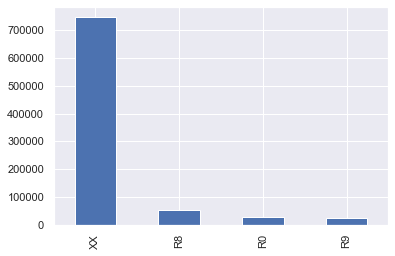

In [259]:
dfColumnasLimpias['COD_TIPO_BOLSA_DESCUENTO'].value_counts().plot(kind='bar')

In [260]:
dfColumnasLimpias['COD_TIPO_BOLSA_DESCUENTO'].value_counts()

XX    746545
R8     52867
R0     25719
R9     24075
Name: COD_TIPO_BOLSA_DESCUENTO, dtype: int64

TODO Parece listo para pasar a one hot

Llegado a este punto, haremos en el conjunto de datos los cambios que teníamos pendientes.

In [261]:
dfColumnasMasLimpias = dfColumnasLimpias.drop(columns=["COD_AGENTE","COD_POSTAL_COND_HABITUAL","COD_POSTAL_COND_PRINCIPAL",
"FEC_CARNET_COND_HABITUAL","FEC_CARNET_COND_PRINCIPAL","FEC_NAC_COND_PRINCIPAL","FEC_NAC_COND_HABITUAL","ID_CIERRE",
"NUM_LOTE_CARTERA","TIPO_OPERACION","DES_FORMA_CONTRATA","DES_BANCO","COD_MODALIDAD_ANT","COD_MODALIDAD_REG",
"COD_MODALIDAD_ANT","NOTA_FACTOR_EXPERIAN","DESC_OFICINA_GESTORA","DESC_OFICINA_ABRIDORA","DESC_TITULACION","DESC_PROFESION",
"DESC_MARCA","DESC_MODELO_VERSION"])

In [262]:
dfColumnasMasLimpias.shape

(849206, 91)

In [263]:
dfColumnasMasLimpias.dtypes

MES_CARTERA                           int64
IND_CARTERA                           int64
FLG_RENUEVA                           int64
FLG_POLIZA_COLECTIVA                  int64
DES_FORMA_PAGO                       object
DES_MODO_PAGO                        object
NUM_SUPLEMENTO_REGULADOR              int64
NUM_SUPLEMENTO                        int64
FEC_ALTA_POLIZA                       int64
FEC_EFECTO_POLIZA                     int64
FEC_VCTO_POLIZA                       int64
COD_MODALIDAD_ACT                    object
VAL_MUT_G                            object
VAL_MUT_5                            object
VAL_MUT_1                            object
NUM_POLIZAS                           int64
NUM_ANTIGUEDAD_POLIZA               float64
NUM_ANTI_MUTUALISTA                 float64
EDAD                                float64
NUM_ANTI_CARNET                     float64
FLG_CONDUCTOR_HAB                     int64
NUM_CONDUCTORES                       int64
COD_PROVINCIA                   

### Filtrado de columnas por valor de negocio
Vamos a eliminar más columnas que sabemos por nuestro conocimiento del negocio que pueden no aportar demasiado valor.
* El campo IMPORTE_TOTAL_DESCUENTO aglutina la suma de todos los descuentos aplicados. Podemos usar este campo y prescidir de las campañas individuales.

In [268]:
columnas_descuentos = ['IMP_DESC_EMPLEADOS_TOTAL','IMP_DESC_COMERCIAL_TOTAL','FLG_DESC_PRECAMPANA','IMP_DESC_PRECAMPANA',
'FLG_DESC_CAMPANA','IMP_DESC_CAMPANA','FLG_DESC_ESPECIAL','IMP_DESC_ESPECIAL','COD_TIPO_BOLSA_DESCUENTO',
'FLG_DESC_BOLSA_RETENCION','IMP_DESC_BOLSA_RETENCION','FLG_DESC_REGULADOR','IMP_DESC_REGULADOR','FLG_PRECAM_BUEN_MUTUALISTA',
'IMP_PRECAM_BUEN_MUTUALISTA','FLG_PRECAM_NUEVO_VEHICULO','IMP_PRECAM_NUEVO_VEHICULO','FLG_PRECAM_MULTIPACK',
'IMP_PRECAM_MULTIPACK','FLG_CAMPANA_EMPLEADOS','IMP_DESC_EMPLEADOS','FLG_CAMP_EMPL_COLABORADOR','IMP_CAMP_EMPL_COLABORADOR',
'FLG_CAMPANA_PROV','IMP_CAMPANA_PROV','FLG_CAMP_MOTOS50','IMP_CAMP_MOTOS50','FLG_CAMP_MUTUALISTA_PROPIETARIO',
'IMP_CAMP_MUTUALISTA_PROPIETARIO','FLG_CAMP_DESC_ESPECIAL','IMP_CAMP_DESC_ESPECIAL']

* El campo FEC_ALTA_POLIZA es redundante ya que vamos a tener NUM_ANTIGUEDAD_POLIZA.
* Pasa un poco lo mismo con FEC_EFECTO_POLIZA
* La FEC_VCTO_POLIZA irá aumentando en el futuro, no vamos a poder usarla para extraer información.
* El COD_VEHICULO no nos vale como tal, tenemos agrupaciones por tipo de vehiculo en otras columnas.

In [271]:
columnas_borrar = ["FEC_ALTA_POLIZA","FEC_EFECTO_POLIZA","FEC_VCTO_POLIZA","COD_VEHICULO"]

In [272]:
columnas_borrar = columnas_borrar + columnas_descuentos

In [275]:
dfColumnasMasLimpias = dfColumnasMasLimpias.drop(columns=columnas_borrar)

KeyError: "['FEC_ALTA_POLIZA' 'FEC_EFECTO_POLIZA' 'FEC_VCTO_POLIZA' 'COD_VEHICULO'\n 'IMP_DESC_EMPLEADOS_TOTAL' 'IMP_DESC_COMERCIAL_TOTAL'\n 'FLG_DESC_PRECAMPANA' 'IMP_DESC_PRECAMPANA' 'FLG_DESC_CAMPANA'\n 'IMP_DESC_CAMPANA' 'FLG_DESC_ESPECIAL' 'IMP_DESC_ESPECIAL'\n 'COD_TIPO_BOLSA_DESCUENTO' 'FLG_DESC_BOLSA_RETENCION'\n 'IMP_DESC_BOLSA_RETENCION' 'FLG_DESC_REGULADOR' 'IMP_DESC_REGULADOR'\n 'FLG_PRECAM_BUEN_MUTUALISTA' 'IMP_PRECAM_BUEN_MUTUALISTA'\n 'FLG_PRECAM_NUEVO_VEHICULO' 'IMP_PRECAM_NUEVO_VEHICULO'\n 'FLG_PRECAM_MULTIPACK' 'IMP_PRECAM_MULTIPACK' 'FLG_CAMPANA_EMPLEADOS'\n 'IMP_DESC_EMPLEADOS' 'FLG_CAMP_EMPL_COLABORADOR'\n 'IMP_CAMP_EMPL_COLABORADOR' 'FLG_CAMPANA_PROV' 'IMP_CAMPANA_PROV'\n 'FLG_CAMP_MOTOS50' 'IMP_CAMP_MOTOS50' 'FLG_CAMP_MUTUALISTA_PROPIETARIO'\n 'IMP_CAMP_MUTUALISTA_PROPIETARIO' 'FLG_CAMP_DESC_ESPECIAL'\n 'IMP_CAMP_DESC_ESPECIAL'] not found in axis"

In [276]:
dfColumnasMasLimpias.shape

(849206, 56)

### Análisis de valores ausentes

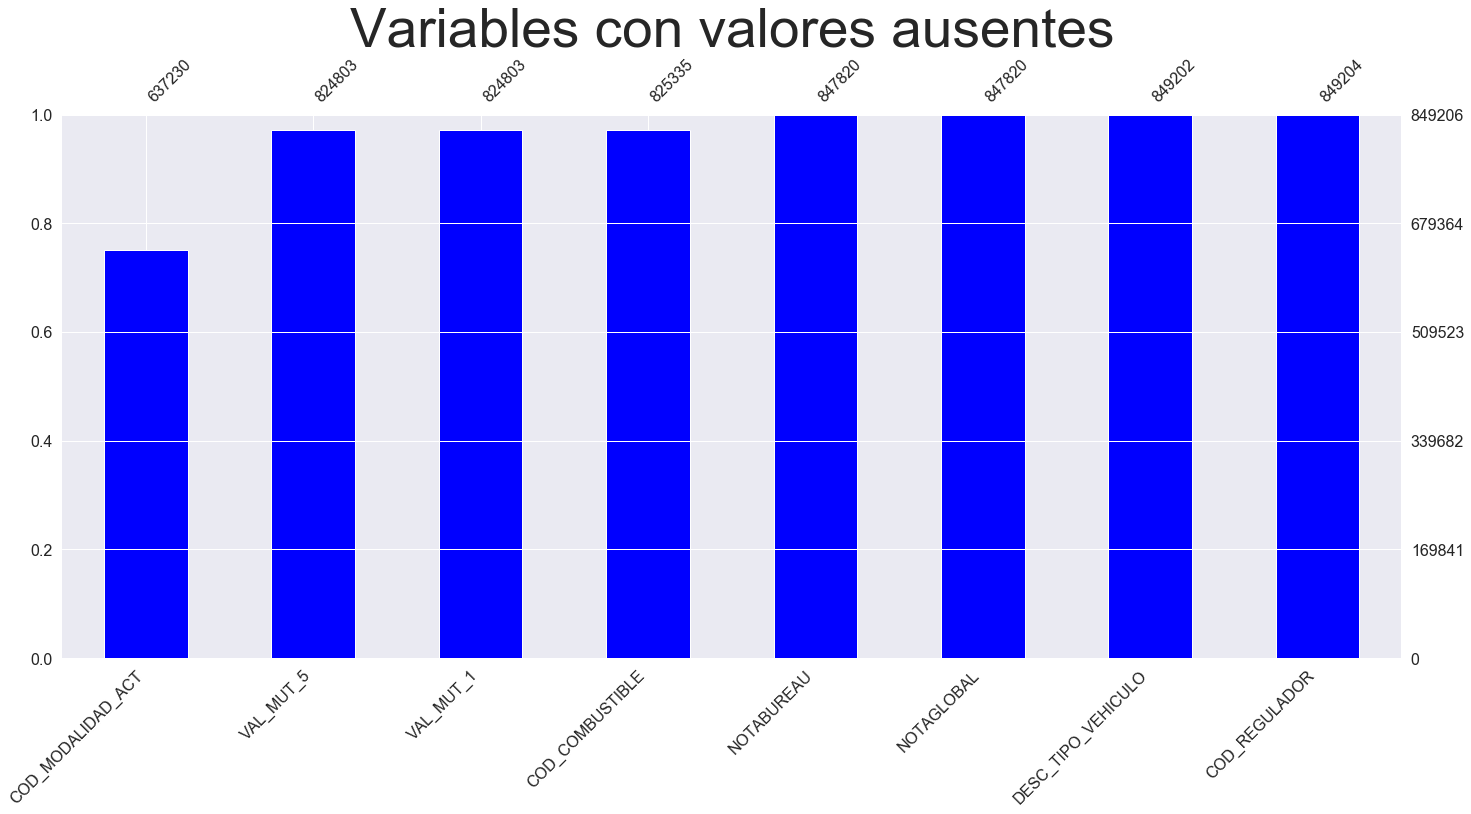

In [278]:
msno.bar(dfColumnasMasLimpias, color='blue', inline=False, filter ='bottom', sort='ascending', n = 8)
plt.title('Variables con valores ausentes', fontsize=55)
plt.show()

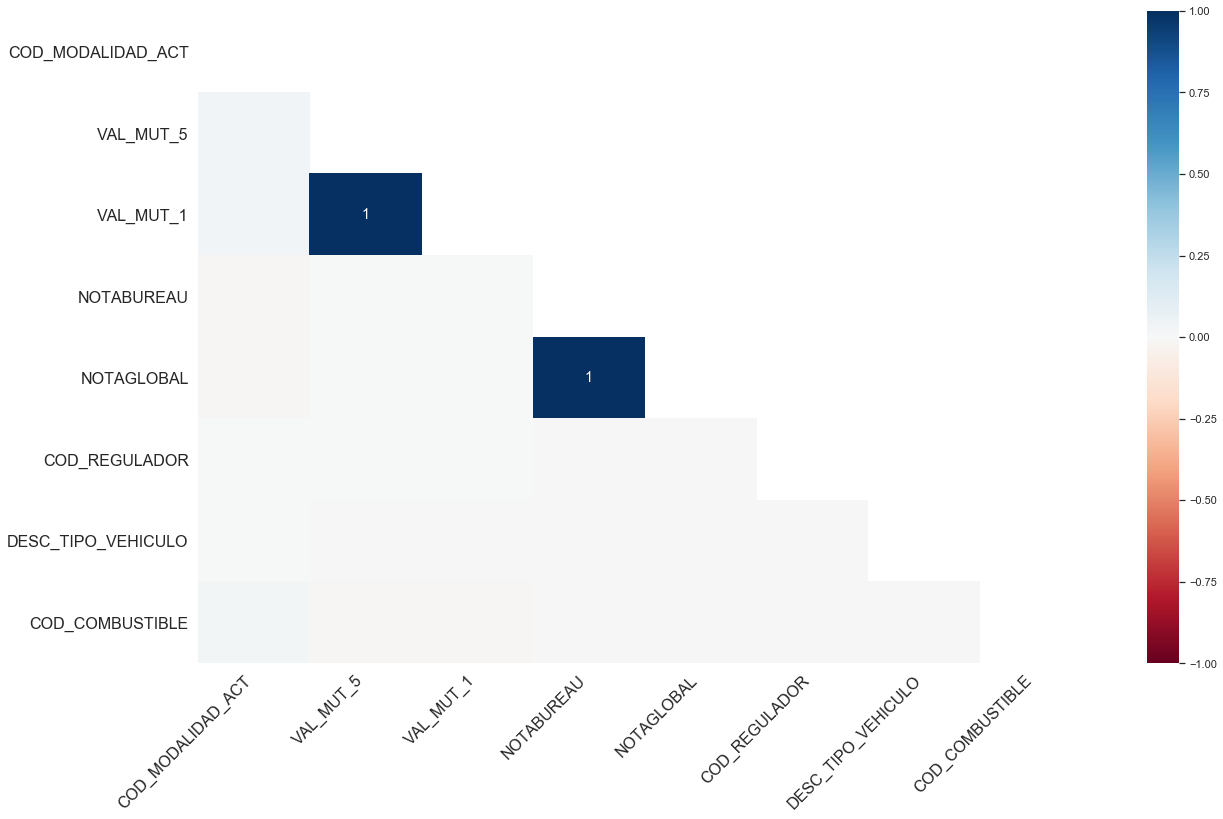

In [279]:
msno.heatmap(dfColumnasMasLimpias)

* Hay [TODO ajustar numero] clientes a los que les falta tanto la valoración de los 5 últimos años como las del último año
* También hay [TODO ajustar numero] clientes a los que les falta la nota global y de bureau
* TODO El campo en el que falta un numero considerable de datos es COD_MODALIDAD_ACT, veamos qué pasa. 

## Análisis de correlación de las variables con target

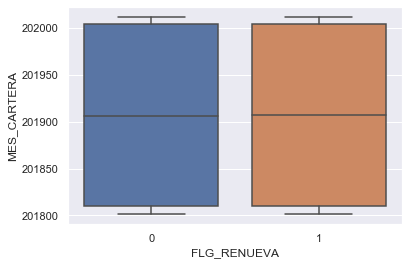

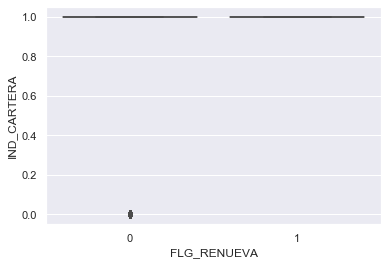

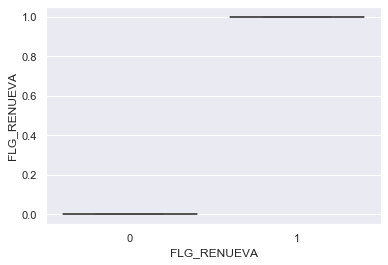

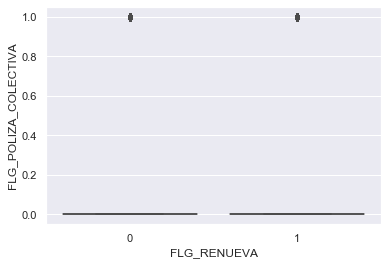

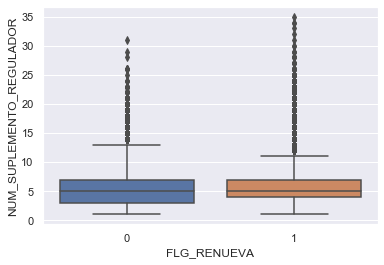

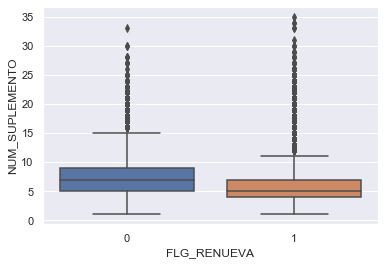

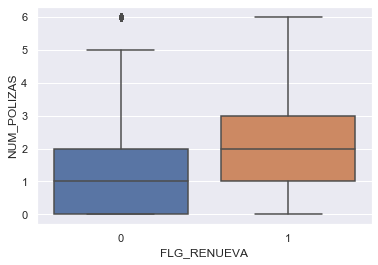

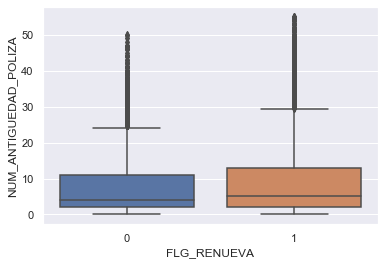

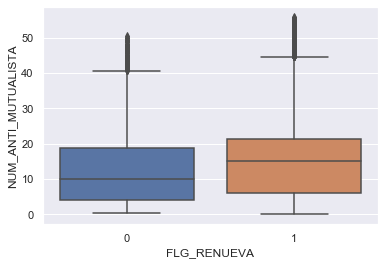

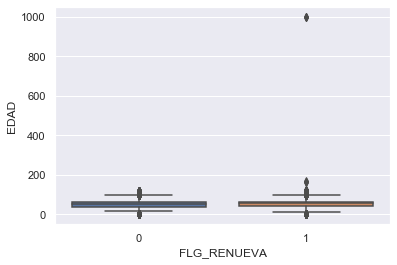

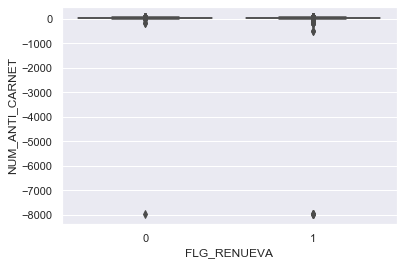

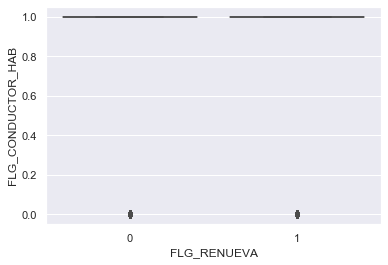

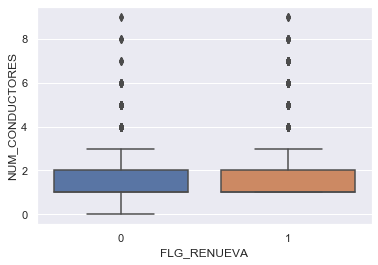

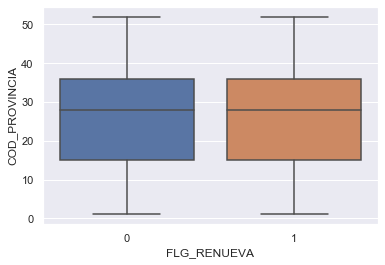

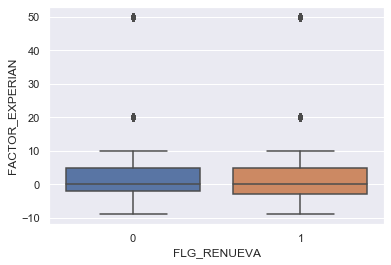

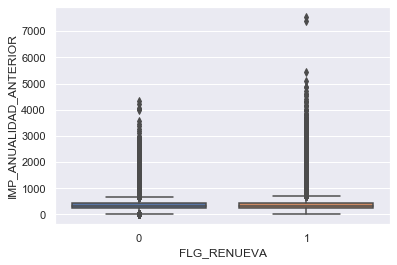

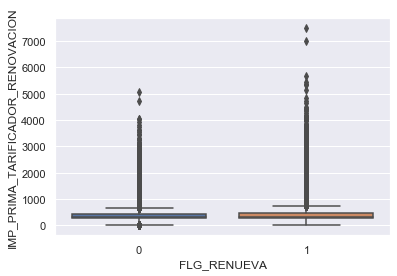

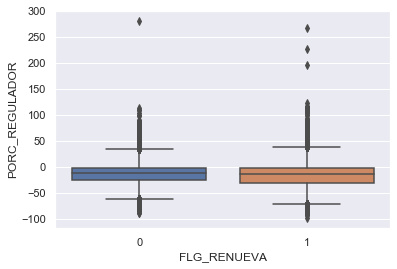

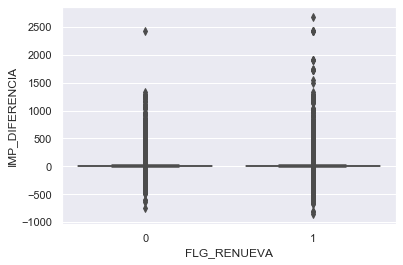

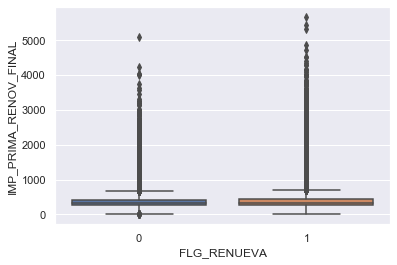

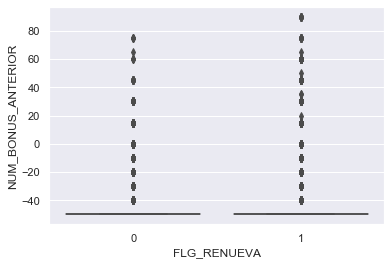

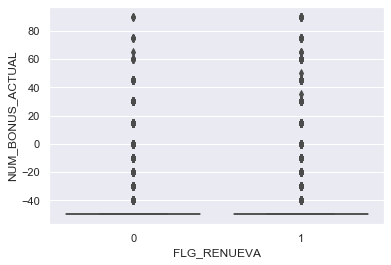

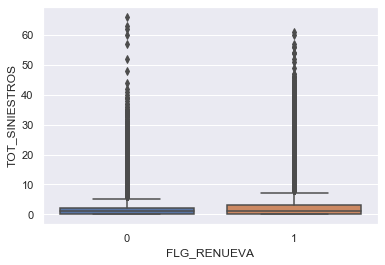

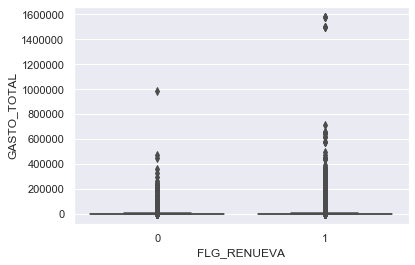

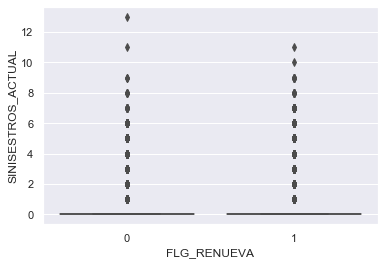

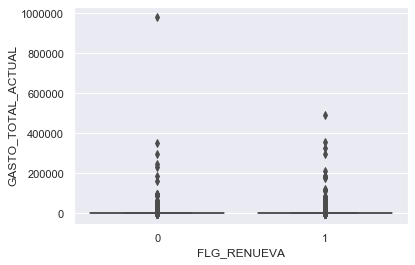

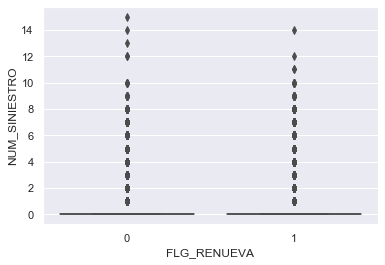

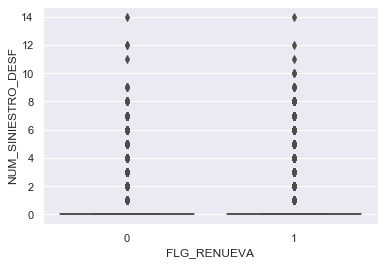

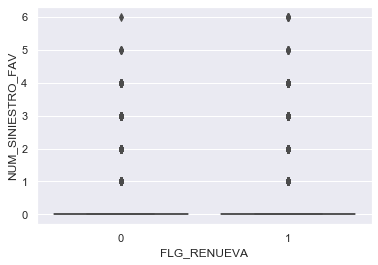

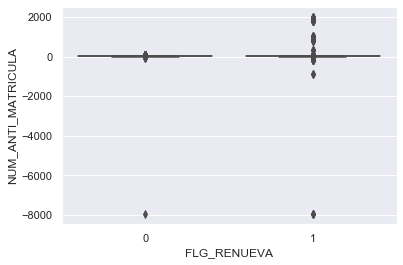

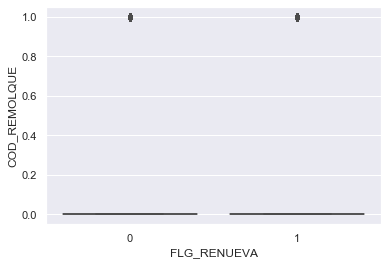

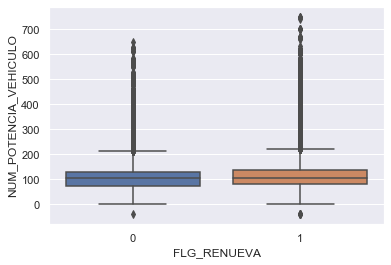

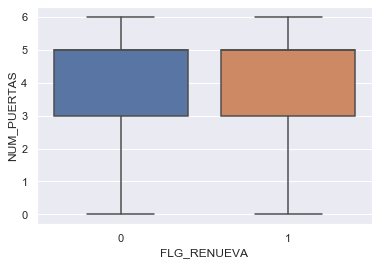

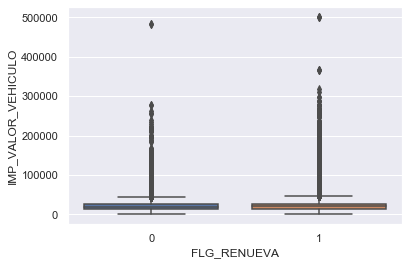

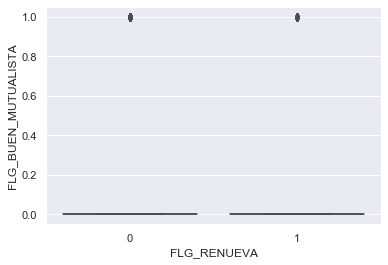

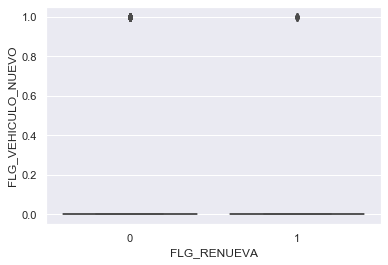

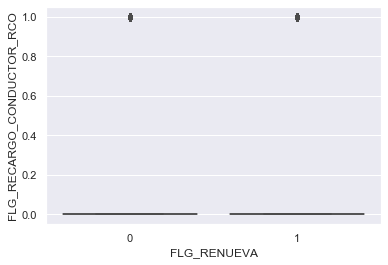

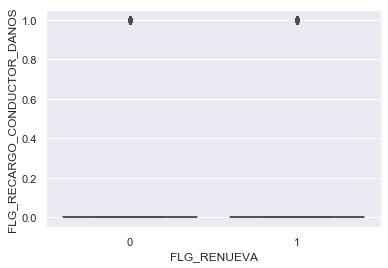

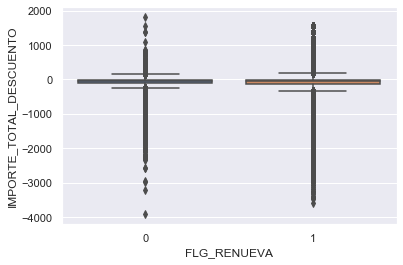

In [301]:
for i, var in enumerate(dfColumnasMasLimpias.describe().columns):
    sns.boxplot(data=dfColumnasMasLimpias, x = 'FLG_RENUEVA', y = var)
    plt.show()

### Matriz de correlaciones

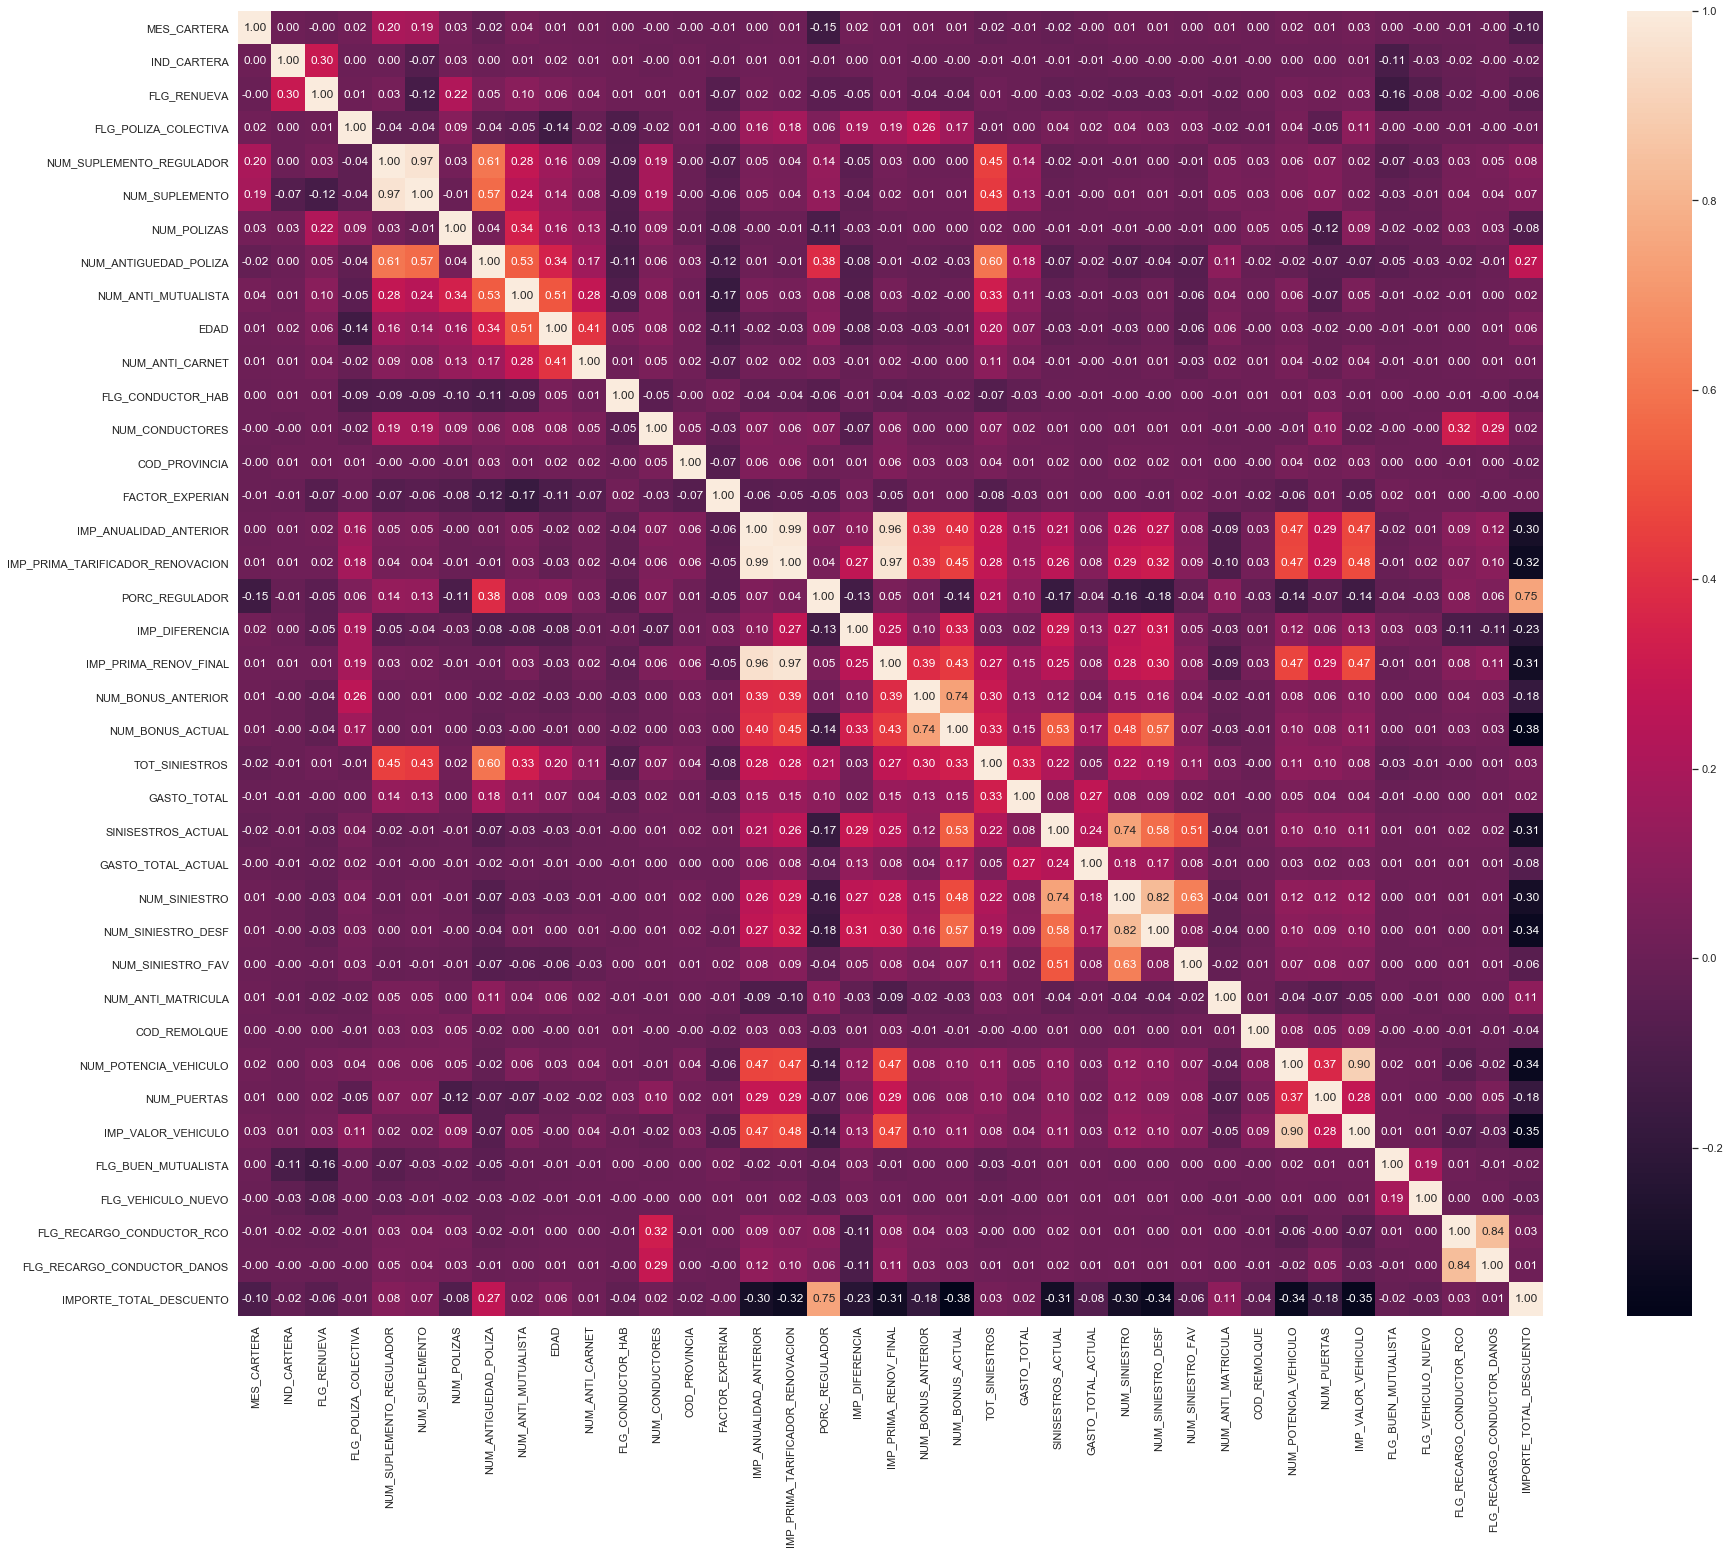

In [302]:
cm = dfColumnasMasLimpias.corr()
f, ax = plt.subplots(figsize=(30, 24))
sns.set(font_scale = 1)
hm = sns.heatmap(cm, cbar=True,annot=True, square=True, fmt='.2f')
plt.show()

### Paso de variables categóricas a numéricas

In [306]:
columnas_dummy = dfColumnasMasLimpias.describe(include='object').columns
columnas_dummy

Index(['DES_FORMA_PAGO', 'DES_MODO_PAGO', 'COD_MODALIDAD_ACT', 'VAL_MUT_G',
       'VAL_MUT_5', 'VAL_MUT_1', 'COD_ZONA_TARIFA', 'NOTABUREAU', 'NOTAGLOBAL',
       'COD_REGULADOR', 'DES_TRAMO_BONUS', 'DES_TIPO_CLIENTE',
       'ID_REL_PROFESION', 'DES_TIPO_SINIESTRO', 'DESC_TIPO_VEHICULO',
       'DESC_GRUPO_TARIFICACION', 'COD_COMBUSTIBLE'],
      dtype='object')

In [305]:
for var in dfColumnasMasLimpias.describe(include='object'):
    categorias = dfColumnasMasLimpias[var].unique()
    num_categorias = len(categorias)
    print('Categorías de', var, ':',categorias)
    print('Categorías distintas:',num_categorias)

Categorías de DES_FORMA_PAGO : ['Anual' 'Semestral' 'Trimestral' 'Unica' 'Semestral sin recargo'
 'Trimestral sin recargo' 'No Informado']
Categorías distintas: 7
Categorías de DES_MODO_PAGO : ['Por Banco' 'Por Caja' 'No Informado']
Categorías distintas: 3
Categorías de COD_MODALIDAD_ACT : ['MB' nan 'MS' 'MI' 'MM' 'ML' 'MF' 'G4' 'CI' 'MX' 'CL' 'XL' 'BB' 'G1' 'G2'
 'MC' '44' 'XI' 'XF' 'G5' 'G6' '34' '19' 'XB' '21' 'G3' 'CB' 'G7' 'G8'
 'XS' 'G9' '39' '15' '06' '46' 'IM' 'RB' 'R1' 'RI' 'MT' 'RL' 'MQ' '81'
 'RM' 'R2' 'RS' 'CX' 'RT' '38' 'CG' '05' '17' '43' '29' '26' '31' '08'
 '23' 'R3']
Categorías distintas: 59
Categorías de VAL_MUT_G : ['AB' 'VI' 'A9' 'B8' 'B5' 'AA' 'AC' 'C1' 'B7' 'C2' 'B6' 'C0' 'B4']
Categorías distintas: 13
Categorías de VAL_MUT_5 : ['A9' 'VI' 'C1' 'B6' nan 'AA' 'B7' 'C0' 'AB' 'C2' 'B5' 'B8' 'B3' 'AC' 'B4']
Categorías distintas: 15
Categorías de VAL_MUT_1 : ['A9' 'VI' 'B6' 'B7' 'C2' 'AA' 'B5' nan 'B8' 'AB' 'AC' 'B4' 'C1' 'C0' 'B3']
Categorías distintas: 15
Categorías d

In [307]:
df_Dummies = pd.get_dummies(dfColumnasMasLimpias, columns=columnas_dummy, drop_first=True)

In [308]:
df_Dummies.shape

(849206, 262)

# Entrenamiento del Modelo

In [309]:
X = df_Dummies.drop(columns=['FLG_RENUEVA'])
y = df_Dummies['FLG_RENUEVA']

In [312]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=25)

#### Decision Tree

In [314]:
model = DecisionTreeClassifier(random_state=25)
model.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=25, splitter='best')

In [315]:
test_predict = model.predict(X_test)
print(classification_report(y_test, test_predict))

              precision    recall  f1-score   support

           0       0.77      0.77      0.77     30058
           1       0.97      0.97      0.97    224704

    accuracy                           0.94    254762
   macro avg       0.87      0.87      0.87    254762
weighted avg       0.94      0.94      0.94    254762



In [316]:
print(confusion_matrix(y_test, test_predict))

[[ 22997   7061]
 [  7061 217643]]


#### Mezcla de modelos

C:\Users\daniel.pascual\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\daniel.pascual\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\daniel.pascual\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\daniel.pascual\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\daniel.pascual\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to '

LR: 0.882388 (0.001664)


C:\Users\daniel.pascual\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\daniel.pascual\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\daniel.pascual\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\daniel.pascual\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\daniel.pascual\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\daniel.pascual\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.w

LDA: 0.940544 (0.001088)
KNN: 0.873413 (0.001926)
CART: 0.943608 (0.000949)
NB: 0.855845 (0.002049)


C:\Users\daniel.pascual\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\daniel.pascual\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\daniel.pascual\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\daniel.pascual\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\daniel.pascual\Anaconda3\lib\si

RF: 0.928017 (0.002545)


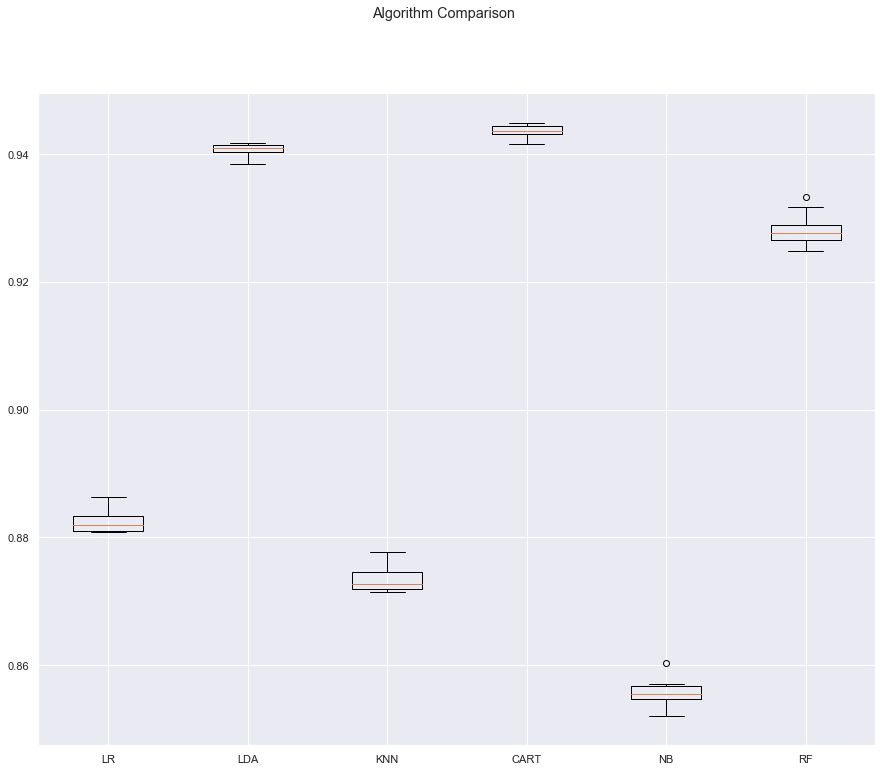

In [319]:
X = X_train
Y = y_train


seed = 7

models = []
models.append(('LR'  , LogisticRegression        ()))
models.append(('LDA' , LinearDiscriminantAnalysis()))
models.append(('KNN' , KNeighborsClassifier      ()))
models.append(('CART', DecisionTreeClassifier    ()))
models.append(('NB'  , GaussianNB                ()))
models.append(('RF' ,  RandomForestClassifier     ()))

results = []
names   = []
scoring = 'accuracy'

for name, model in models:
    kfold = model_selection.KFold(n_splits=10, random_state=seed)
    cv_results = model_selection.cross_val_score(model, X, Y, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

fig = plt.figure()
fig.set_size_inches(15, 12)
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()